# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS2024

Original von S. Suter, angepasst von S. Marcin und M. Stutz

Abgabe von: <font color='blue'>Dominik Filliger</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe Ordner "resources"
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [1]:

import os
import glob
import imageio
import logging
import numpy as np
import cupy as cp
import time
from numba import cuda, vectorize, float32
import matplotlib.pyplot as plt

# TODO REMOVE FOR FINAL SUBMISSION
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def load_mri_images(subfolder='001'):
    """Load MRI images from the specified subfolder"""
    try:
        folders = os.path.join('adni_png', subfolder)
        if not os.path.exists(folders):
            raise FileNotFoundError(f"MRI image folder not found: {folders}")
        
        files = sorted(glob.glob(f"{folders}/*.png"))
        if not files:
            raise FileNotFoundError(f"No MRI images found in {folders}")
        
        images = np.array([imageio.imread(f) for f in files], dtype=np.float32)
        names = [f[-17:-4] for f in files]
        logger.info(f"Successfully loaded {len(images)} MRI images from {subfolder}")
        return images, names
    except Exception as e:
        logger.error(f"Error loading MRI images: {str(e)}")
        raise

In [2]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

INFO:numba.cuda.cudadrv.driver:init
/home/paperspace/hs24-mc2-dmnkf/.venv/lib/python3.12/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16384 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16384 bytes


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [3]:
### BEGIN SOLUTION
import math
import numpy as np
import cupy as cp
from numba import cuda
import time
import matplotlib.pyplot as plt
import timeit

# todo 1
def reconstruct_svd_broadcast1(u,s,vt,k):
    ### BEGIN SOLUTION
    reco = u[:,:k] * s[:k] @ vt[:k,:]
    ### END SOLUTION
    return reco

def reconstruct_svd_cp(u, s, vt, k):
    """
    Perform SVD reconstruction using CuPy's built-in dot product.
    """
    return cp.asnumpy(cp.dot(u[:,:k], cp.dot(cp.diag(s[:k]), vt[:k,:])))

def reconstruct_svd_cp_einsum(u, s, vt, k):
    """
    Perform SVD reconstruction using CuPy and einsum for matrix multiplication.
    """
    return cp.asnumpy(cp.einsum('ik,k,kj->ij', u[:,:k], s[:k], vt[:k,:]))

def reconstruct_svd_cp_broadcast(u, s, vt, k):
    """
    CuPy SVD reconstruction using broadcasting for the multiplication of S.
    """
    return cp.asnumpy(cp.dot(u[:,:k], cp.multiply(s[:k].reshape(-1, 1), vt[:k,:])))

@cuda.jit
def reconstruct_svd_kernel(u, s, vt, out, k):
    """
    CUDA kernel that reconstructs a matrix from SVD components:
      out = u * s * vt, up to rank k.
    """
    i, j = cuda.grid(2)
    if i < u.shape[0] and j < vt.shape[1]:
        tmp = 0.0
        for r in range(k):
            tmp += u[i, r] * s[r] * vt[r, j]
        out[i, j] = tmp

def reconstruct_svd_numba(u, s, vt, k):
    """
    Multiply U, S, and V^T on the GPU using a custom CUDA kernel.
    """
    U_k = u[:,:k]
    S_k = s[:k]
    VT_k = vt[:k,:]

    # Prepare output on GPU
    out = np.zeros((U_k.shape[0], VT_k.shape[1]), dtype=np.float32)

    # Launch kernel
    threads_per_block = (16, 16)
    blocks_per_grid = (
        math.ceil(U_k.shape[0] / threads_per_block[0]),
        math.ceil(VT_k.shape[1] / threads_per_block[1])
    )
    reconstruct_svd_kernel[blocks_per_grid, threads_per_block](U_k, S_k, VT_k, out, S_k.shape[0])
    return out

### END SOLUTION

/tmp/ipykernel_157721/2657079973.py:26: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = np.array([imageio.imread(f) for f in files], dtype=np.float32)
INFO:__main__:Successfully loaded 35 MRI images from 001
/home/paperspace/hs24-mc2-dmnkf/.venv/lib/python3.12/site-packages/numba/cuda/cudadrv/devicearray.py:888: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driv

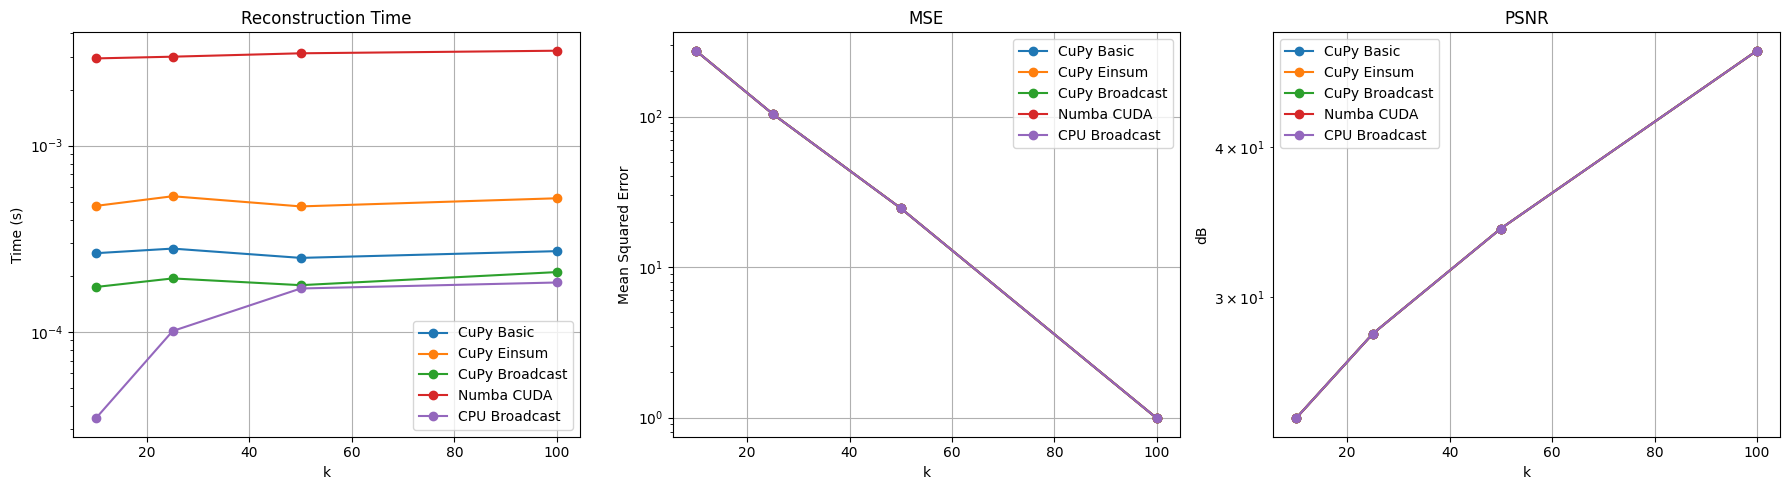

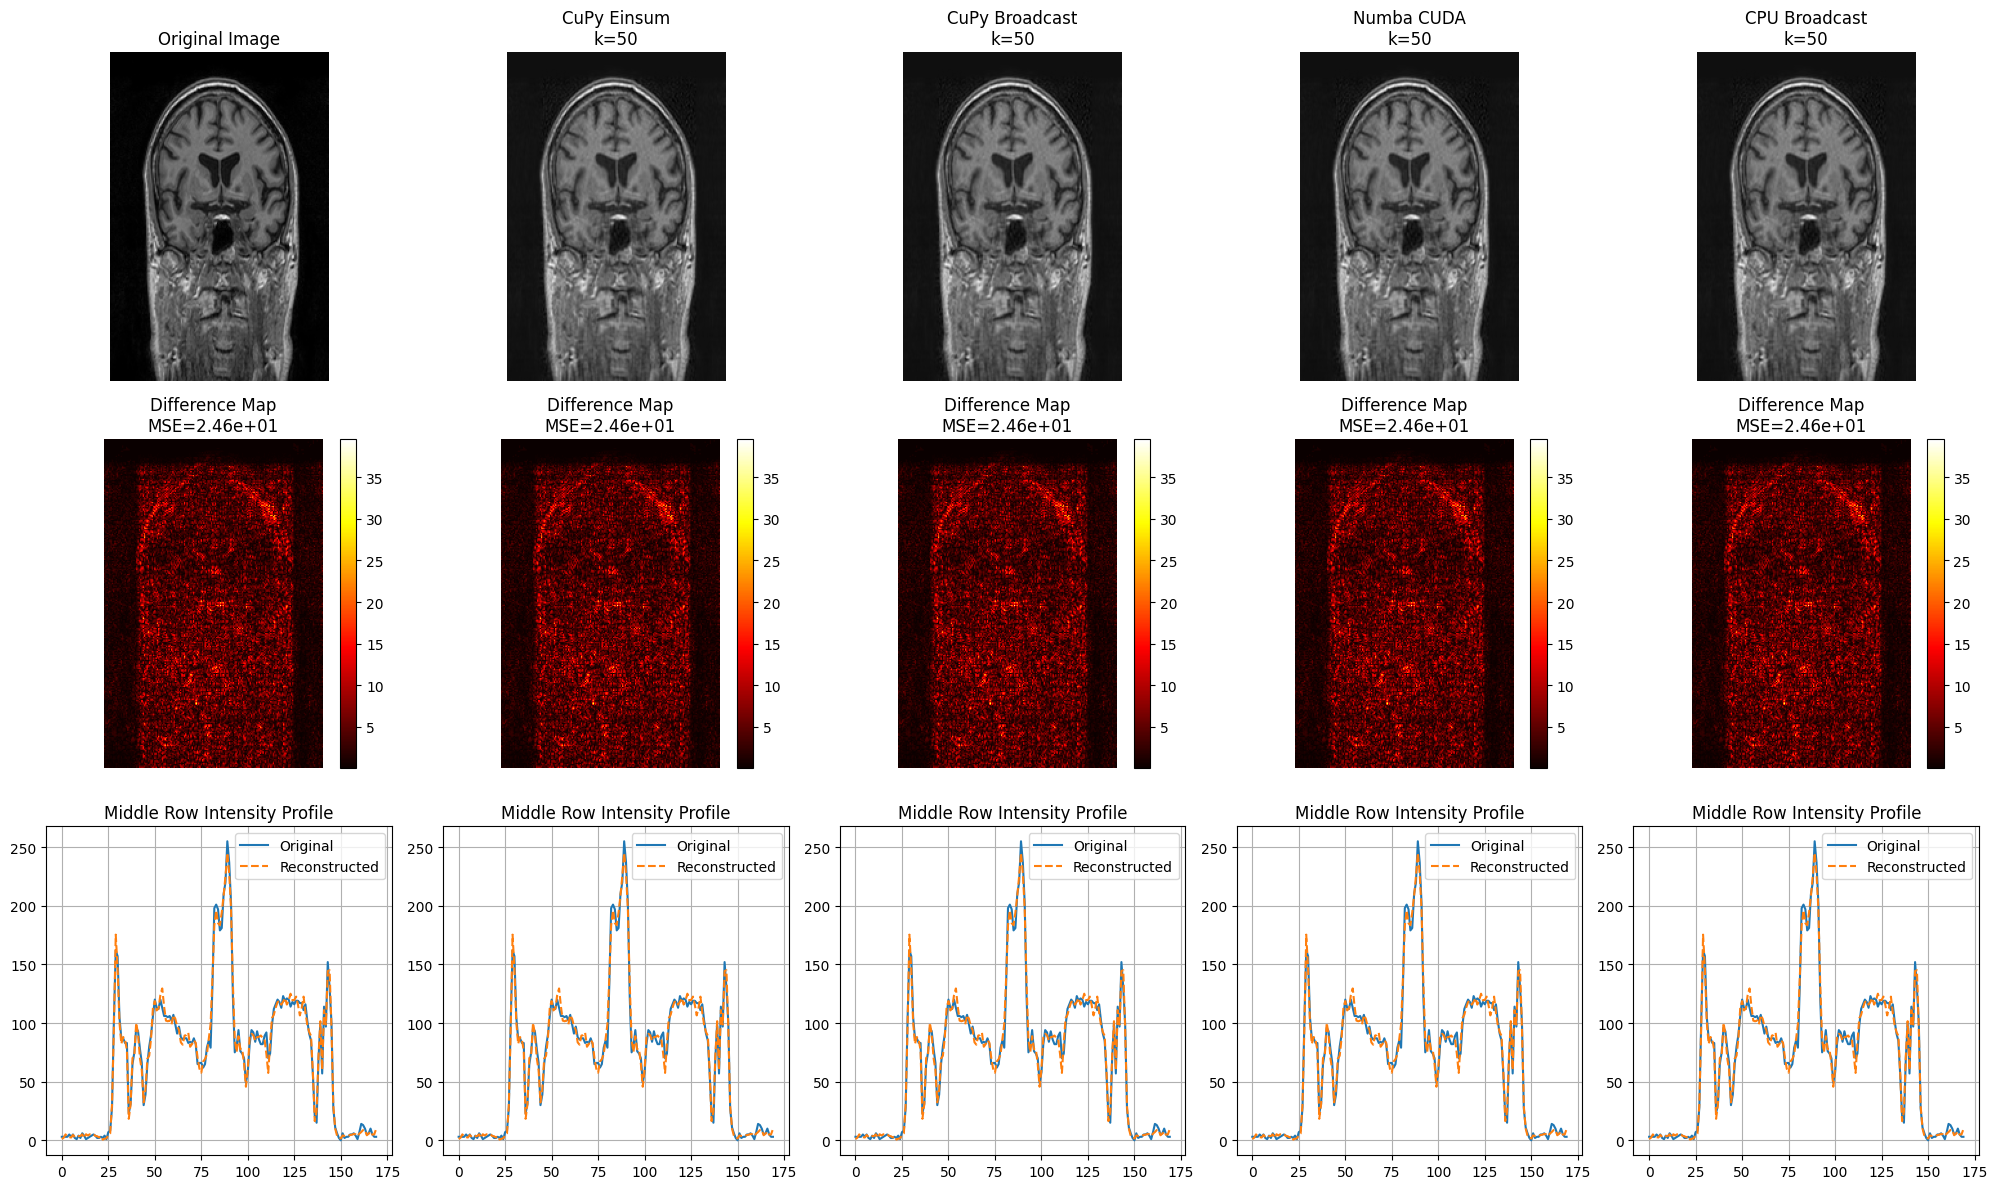

In [4]:

def measure_metrics(original, reconstructed):
    """
    Compute MSE and PSNR for the given original and reconstructed images.
    """
    mse = np.mean((original - reconstructed) ** 2)
    if mse == 0:  # Perfect reconstruction
        psnr = float('inf')
    else:
        psnr = round(20 * np.log10(255.0 / np.sqrt(mse)), 5)
    return mse, psnr

def plot_reconstruction_comparison(test_image, k_values=(10, 25, 50, 100)):
    """
    For each method, reconstruct the test_image with various k-values,
    measuring decomposition and reconstruction times separately.
    """
    implementations = {
        'CuPy Basic': reconstruct_svd_cp,
        'CuPy Einsum': reconstruct_svd_cp_einsum,
        'CuPy Broadcast': reconstruct_svd_cp_broadcast,
        'Numba CUDA': reconstruct_svd_numba,
        'CPU Broadcast': reconstruct_svd_broadcast1,
    }

    results = {name: [] for name in implementations}

    # Perform SVD decomposition once
    U, S, VT = np.linalg.svd(test_image, full_matrices=False)

    # Pre-transfer data to GPU for GPU implementations
    U_gpu = cp.asarray(U, dtype=cp.float32)
    S_gpu = cp.asarray(S, dtype=cp.float32)
    VT_gpu = cp.asarray(VT, dtype=cp.float32)

    for k in k_values:
        first_mse = None
        first_psnr = None
        
        for name, func in implementations.items():
            recon_times, mse_list, psnr_list = [], [], []
            
            # Prepare inputs based on implementation type
            if name == 'CPU Broadcast':
                u_input, s_input, vt_input = U, S, VT
            else:
                u_input, s_input, vt_input = U_gpu, S_gpu, VT_gpu
                # warmup
                func(u_input, s_input, vt_input, k)

            recon_time = timeit.timeit(
                lambda: func(u_input, s_input, vt_input, k),
                number=1000
            ) / 1000
            reconstructed = func(u_input, s_input, vt_input, k)
            
            mse, psnr = measure_metrics(test_image, reconstructed)
            
            # Store first MSE/PSNR values to compare against
            if first_mse is None:
                first_mse = mse
            else:
                # Assert that MSE and PSNR are equal across implementations
                assert np.allclose(mse, first_mse, rtol=1e-5), f"MSE mismatch for {name}"

            results[name].append({
                'k': k,
                'recon_time': recon_time,
                'mse': mse,
                'psnr': psnr,
                'reconstructed': reconstructed
            })

    # Plot reconstruction time, MSE, PSNR
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for name, data in results.items():
        k_list = [d['k'] for d in data]
        recon_times = [d['recon_time'] for d in data]
        mse_list = [d['mse'] for d in data]
        psnr_list = [d['psnr'] for d in data]

        axes[0].plot(k_list, recon_times, '-o', label=name)
        axes[1].plot(k_list, mse_list, '-o', label=name)
        axes[2].plot(k_list, psnr_list, '-o', label=name)

    axes[0].set_title('Reconstruction Time')
    axes[0].set_xlabel('k')
    axes[0].set_ylabel('Time (s)')
    axes[0].set_yscale('log')

    axes[1].set_title('MSE')
    axes[1].set_xlabel('k')
    axes[1].set_ylabel('Mean Squared Error')
    # log scale
    axes[1].set_yscale('log')

    axes[2].set_title('PSNR')
    axes[2].set_xlabel('k')
    axes[2].set_ylabel('dB')
    # log scale
    axes[2].set_yscale('log')

    for ax in axes:
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot reconstructions and difference maps for k=50
    k_idx = k_values.index(50)  # Get index of k=50 results
    
    # Create figure with subplots
    n_methods = len(implementations)
    fig, axes = plt.subplots(3, n_methods, figsize=(4*n_methods, 12))
    
    # Plot original image in first row, first column
    axes[0,0].imshow(test_image, cmap='gray')
    axes[0,0].set_title('Original Image')
    axes[0,0].axis('off')
    
    for idx, (name, method_results) in enumerate(results.items()):
        reconstructed = method_results[k_idx]['reconstructed']
        diff_map = np.abs(test_image - reconstructed)
        
        # Plot reconstructed image
        if idx > 0:  # Skip first column of first row (used for original)
            axes[0,idx].imshow(reconstructed, cmap='gray')
            axes[0,idx].set_title(f'{name}\nk=50')
            axes[0,idx].axis('off')
        
        # Plot difference map
        im = axes[1,idx].imshow(diff_map, cmap='hot')
        axes[1,idx].set_title(f'Difference Map\nMSE={method_results[k_idx]["mse"]:.2e}')
        axes[1,idx].axis('off')
        plt.colorbar(im, ax=axes[1,idx])
        
        # Plot intensity profile
        middle_row = test_image.shape[0]//2
        axes[2,idx].plot(test_image[middle_row,:], label='Original')
        axes[2,idx].plot(reconstructed[middle_row,:], '--', label='Reconstructed')
        axes[2,idx].set_title('Middle Row Intensity Profile')
        axes[2,idx].legend()
        axes[2,idx].grid(True)
    
    plt.tight_layout()
    plt.show()

images, names = load_mri_images(subfolder='001')
test_image = np.ascontiguousarray(images[0])

plot_reconstruction_comparison(test_image)

<font color='blue'>Antwort hier eingeben</font>

#### 5.2 GPU-Kernel Performance

##### 5.2.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

In [5]:
# matrix_sizes = [512, 1024, 2048, 4096, 8192]
matrix_sizes = [512, 1024, 2048, 4096]


# Block configurations to test - powers of 2, respecting max 1024 threads
block_configs = [
    (x, y) for x, y in [
        (2**i, 2**j) 
        for i in range(1,6) 
        for j in range(1,9)
    ] if x * y <= 1024 and x <= y
]


# Precompute SVD decompositions for each matrix size
svd_components = {}
for N in matrix_sizes:
    A = np.random.randn(N, N).astype(np.float32)
    u, s, vt = np.linalg.svd(A, full_matrices=False)
    k = min(u.shape[1], vt.shape[0]) // 3
    svd_components[N] = {
        'u': u,
        's': s,
        'vt': vt,
        'k': k
    }

    cpu_time = timeit.timeit(lambda: reconstruct_svd_broadcast1(u, s, vt, k), number=100) / 100
    
    svd_components[N]['cpu_time'] = cpu_time


In [6]:
results_basic = []

for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    k = svd_components[N]['k']
    
    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        threadsperblock = block_size
        blockspergrid_x = math.ceil(N / threadsperblock[0])
        blockspergrid_y = math.ceil(N / threadsperblock[1])
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        
        # Warm-up run
        reconstruct_svd_kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        
        start_event = cuda.event()
        stop_event = cuda.event()
        # Timed run
        start_event.record()
        reconstruct_svd_kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        stop_event.record()
        gpu_time = cuda.event_elapsed_time(start_event, stop_event) / 1000
        
        C_gpu = C_device.copy_to_host()
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_basic.append({
            'kernel': 'basic',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
        
    # Clean up device memory
    del u_device, s_device, vt_device, C_device

INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba

Block size (2, 2): GPU time = 0.0116s, Speedup = 0.09x
Block size (2, 4): GPU time = 0.0059s, Speedup = 0.17x
Block size (2, 8): GPU time = 0.0030s, Speedup = 0.34x
Block size (2, 16): GPU time = 0.0016s, Speedup = 0.64x
Block size (2, 32): GPU time = 0.0016s, Speedup = 0.64x
Block size (2, 64): GPU time = 0.0016s, Speedup = 0.64x
Block size (2, 128): GPU time = 0.0017s, Speedup = 0.59x
Block size (2, 256): GPU time = 0.0017s, Speedup = 0.61x
Block size (4, 4): GPU time = 0.0031s, Speedup = 0.33x
Block size (4, 8): GPU time = 0.0018s, Speedup = 0.57x
Block size (4, 16): GPU time = 0.0017s, Speedup = 0.58x
Block size (4, 32): GPU time = 0.0017s, Speedup = 0.58x
Block size (4, 64): GPU time = 0.0016s, Speedup = 0.62x
Block size (4, 128): GPU time = 0.0017s, Speedup = 0.58x
Block size (4, 256): GPU time = 0.0019s, Speedup = 0.54x
Block size (8, 8): GPU time = 0.0017s, Speedup = 0.59x
Block size (8, 16): GPU time = 0.0017s, Speedup = 0.60x
Block size (8, 32): GPU time = 0.0019s, Speedup = 

INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dea

Block size (2, 2): GPU time = 0.0719s, Speedup = 0.04x
Block size (2, 4): GPU time = 0.0246s, Speedup = 0.12x
Block size (2, 8): GPU time = 0.0124s, Speedup = 0.24x
Block size (2, 16): GPU time = 0.0064s, Speedup = 0.46x
Block size (2, 32): GPU time = 0.0064s, Speedup = 0.47x
Block size (2, 64): GPU time = 0.0063s, Speedup = 0.47x
Block size (2, 128): GPU time = 0.0063s, Speedup = 0.47x
Block size (2, 256): GPU time = 0.0067s, Speedup = 0.44x
Block size (4, 4): GPU time = 0.0124s, Speedup = 0.24x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pendi

Block size (4, 8): GPU time = 0.0079s, Speedup = 0.38x
Block size (4, 16): GPU time = 0.0063s, Speedup = 0.47x
Block size (4, 32): GPU time = 0.0064s, Speedup = 0.47x
Block size (4, 64): GPU time = 0.0063s, Speedup = 0.47x
Block size (4, 128): GPU time = 0.0064s, Speedup = 0.47x
Block size (4, 256): GPU time = 0.0065s, Speedup = 0.46x
Block size (8, 8): GPU time = 0.0063s, Speedup = 0.47x
Block size (8, 16): GPU time = 0.0063s, Speedup = 0.48x
Block size (8, 32): GPU time = 0.0064s, Speedup = 0.46x
Block size (8, 64): GPU time = 0.0064s, Speedup = 0.47x
Block size (8, 128): GPU time = 0.0065s, Speedup = 0.46x
Block size (16, 16): GPU time = 0.0074s, Speedup = 0.40x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 2048 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cud

Block size (16, 32): GPU time = 0.0063s, Speedup = 0.47x
Block size (16, 64): GPU time = 0.0065s, Speedup = 0.46x
Block size (32, 32): GPU time = 0.0118s, Speedup = 0.25x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.3867s, Speedup = 0.05x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.1937s, Speedup = 0.11x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0972s, Speedup = 0.22x
Block size (2, 16): GPU time = 0.0502s, Speedup = 0.42x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0491s, Speedup = 0.43x
Block size (2, 64): GPU time = 0.0499s, Speedup = 0.42x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0498s, Speedup = 0.42x
Block size (2, 256): GPU time = 0.0495s, Speedup = 0.42x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0985s, Speedup = 0.21x
Block size (4, 8): GPU time = 0.0510s, Speedup = 0.41x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0497s, Speedup = 0.42x
Block size (4, 32): GPU time = 0.0495s, Speedup = 0.42x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pendi

Block size (4, 64): GPU time = 0.0497s, Speedup = 0.42x
Block size (4, 128): GPU time = 0.0495s, Speedup = 0.42x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0500s, Speedup = 0.42x
Block size (8, 8): GPU time = 0.0513s, Speedup = 0.41x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driv

Block size (8, 16): GPU time = 0.0502s, Speedup = 0.42x
Block size (8, 32): GPU time = 0.0496s, Speedup = 0.42x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0497s, Speedup = 0.42x
Block size (8, 128): GPU time = 0.0500s, Speedup = 0.42x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0513s, Speedup = 0.41x
Block size (16, 32): GPU time = 0.0506s, Speedup = 0.42x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8192 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes


Block size (16, 64): GPU time = 0.0509s, Speedup = 0.41x
Block size (32, 32): GPU time = 0.0913s, Speedup = 0.23x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 3.1141s, Speedup = 0.04x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 1.5611s, Speedup = 0.09x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.7865s, Speedup = 0.18x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.4045s, Speedup = 0.35x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.4017s, Speedup = 0.35x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.4021s, Speedup = 0.35x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.4019s, Speedup = 0.35x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.4025s, Speedup = 0.35x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.8053s, Speedup = 0.17x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.4133s, Speedup = 0.34x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.4071s, Speedup = 0.34x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.4054s, Speedup = 0.35x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.4050s, Speedup = 0.35x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.4051s, Speedup = 0.35x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.4073s, Speedup = 0.34x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.4204s, Speedup = 0.33x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.4124s, Speedup = 0.34x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.4080s, Speedup = 0.34x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.4080s, Speedup = 0.34x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.4099s, Speedup = 0.34x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.4200s, Speedup = 0.33x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.4161s, Speedup = 0.34x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.4195s, Speedup = 0.33x


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16384 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4096 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 8192 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 6710886

Block size (32, 32): GPU time = 0.7418s, Speedup = 0.19x


In [7]:
def plot_results(results, kernel_name):
    """
    Plot heatmaps and bar plots for each matrix size showing GPU times and CPU comparison.
    """
    # Extract unique sizes and configurations
    block_sizes = sorted(list(set([tuple(r['block_size']) for r in results])))
    matrix_sizes = sorted(list(set(r['matrix_size'] for r in results)))
    
    # Prepare data structures
    gpu_times = {}
    cpu_times = {}
    
    # Organize data
    for r in results:
        bs = tuple(r['block_size'])
        N = r['matrix_size']
        gpu_times.setdefault(bs, {})[N] = r['gpu_time']
        if N not in cpu_times:
            cpu_times[N] = r['cpu_time']
    
    # Create subplots for each matrix size
    for N in matrix_sizes:
        plt.figure(figsize=(18, 5))
        
        # --- Left subplot: Heatmap
        plt.subplot(1, 2, 1)
        
        # Extract block dimensions for heatmap axes
        block_x = sorted(list(set([bs[0] for bs in block_sizes])))
        block_y = sorted(list(set([bs[1] for bs in block_sizes])))
        
        # Create heatmap data - fill lower triangle
        heatmap_data = np.zeros((len(block_x), len(block_y)))
        for i, bx in enumerate(block_x):
            for j, by in enumerate(block_y):
                if (bx, by) in gpu_times and N in gpu_times[(bx, by)]:
                    heatmap_data[i,j] = gpu_times[(bx, by)][N]
                else:
                    heatmap_data[i,j] = np.nan
        
        # Find minimum time (excluding NaN values)
        min_time = np.nanmin(heatmap_data)
        
        plt.imshow(heatmap_data, cmap='magma_r', aspect='auto')  # Reversed colormap so lowest time is highlighted
        plt.colorbar(label='Time (s)')
        plt.title(f'{kernel_name} GPU Times Heatmap - Matrix Size {N}x{N}\nBest time: {min_time:.4f}s')
        plt.xlabel('Block Y Size')
        plt.ylabel('Block X Size')
        plt.xticks(range(len(block_y)), block_y)
        plt.yticks(range(len(block_x)), block_x)
        
        # Highlight the minimum value
        min_idx = np.where(heatmap_data == min_time)
        plt.plot(min_idx[1], min_idx[0], 'r*', markersize=15, label=f'Best: {min_time:.4f}s')
        plt.legend()
        
        # --- Right subplot: Bar plot
        plt.subplot(1, 2, 2)
        
        # Prepare data for bar plot
        gpu_times_N = []
        gpu_labels = []
        
        for bs in block_sizes:
            if N in gpu_times[bs]:
                gpu_times_N.append(gpu_times[bs][N])
                gpu_labels.append(f'Block {bs}')
        
        # Sort by execution time
        sorted_indices = np.argsort(gpu_times_N)
        sorted_times = [gpu_times_N[i] for i in sorted_indices]
        sorted_labels = [gpu_labels[i] for i in sorted_indices]
        
        # Create bar plot
        bars = plt.bar(range(len(sorted_times)), sorted_times)
        plt.xticks(range(len(sorted_times)), sorted_labels, rotation=45, ha='right')
        
        # Add CPU time reference line
        plt.axhline(y=cpu_times[N], color='r', linestyle='--', label=f'CPU Time')
        
        plt.yscale('log')
        plt.ylabel('Time (s)')
        plt.title(f'Execution Times - Matrix Size {N}x{N}')
        plt.grid(True, which='both', ls='-', alpha=0.2)
        plt.legend()
        
        plt.tight_layout()
        plt.show()



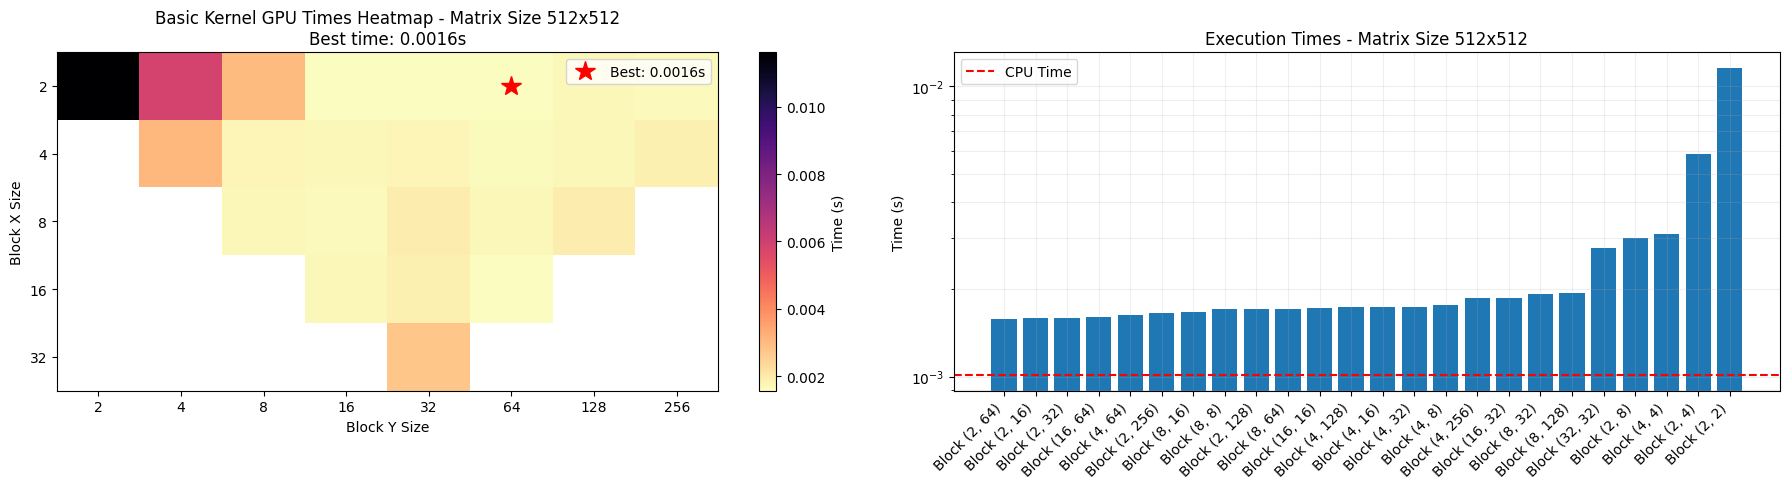

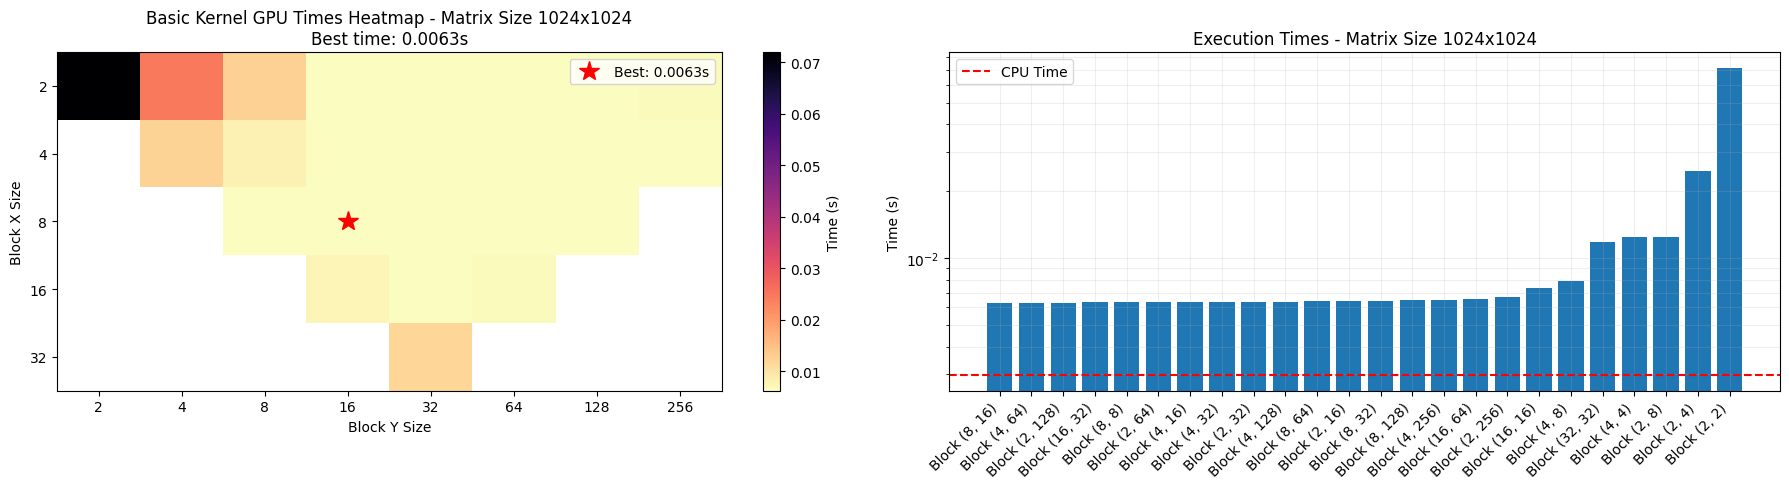

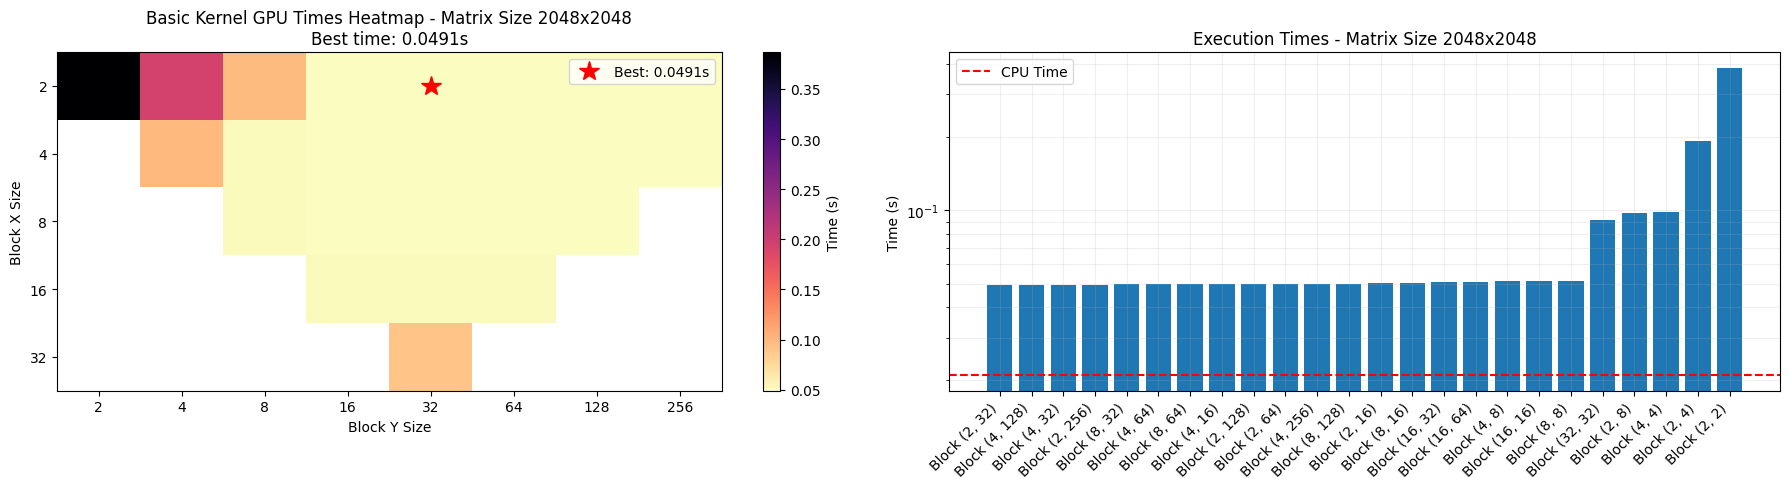

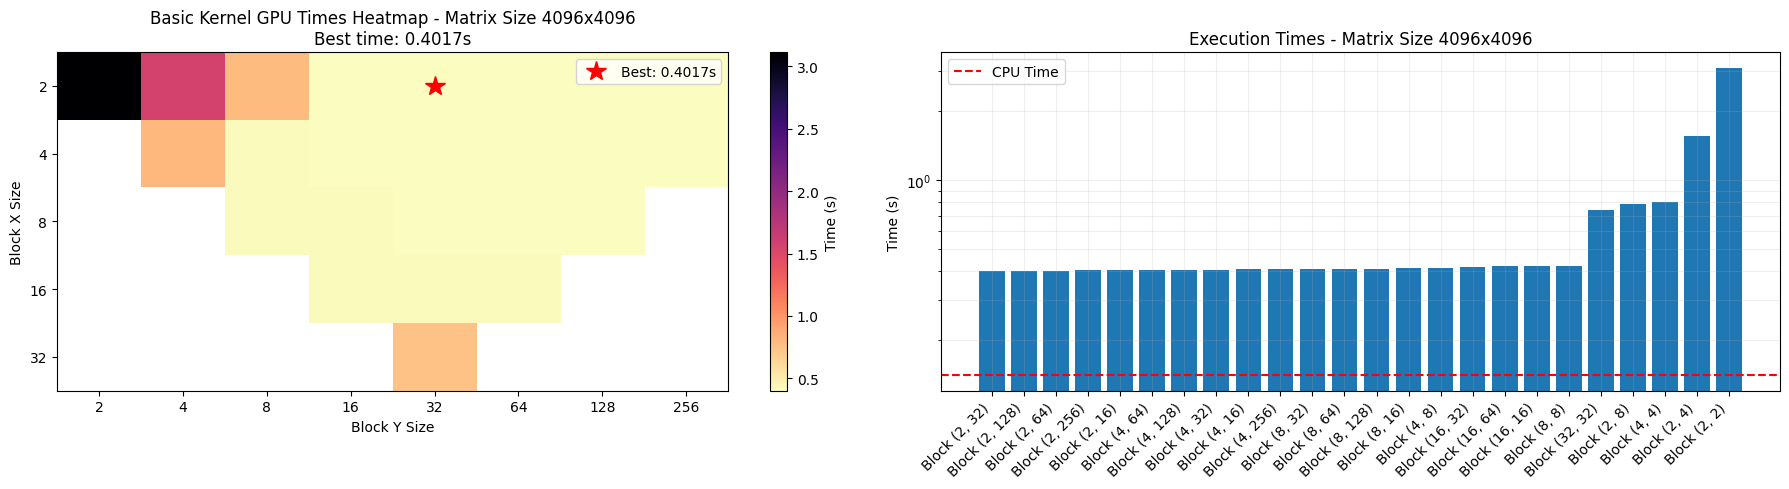


=== Best Configuration for Basic Kernel (Matrix Size 512x512) ===
Block Size: (2, 64)
GPU Time: 0.0016 seconds
Speedup over CPU: 0.64x

=== Best Configuration for Basic Kernel (Matrix Size 1024x1024) ===
Block Size: (8, 16)
GPU Time: 0.0063 seconds
Speedup over CPU: 0.48x

=== Best Configuration for Basic Kernel (Matrix Size 2048x2048) ===
Block Size: (2, 32)
GPU Time: 0.0491 seconds
Speedup over CPU: 0.43x

=== Best Configuration for Basic Kernel (Matrix Size 4096x4096) ===
Block Size: (2, 32)
GPU Time: 0.4017 seconds
Speedup over CPU: 0.35x


In [8]:
plot_results(results_basic, 'Basic Kernel')

for N in matrix_sizes:
    # Filter results for this matrix size
    results_N = [r for r in results_basic if r['matrix_size'] == N]
    best_basic = min(results_N, key=lambda x: x['gpu_time'])
    
    print(f"\n=== Best Configuration for Basic Kernel (Matrix Size {N}x{N}) ===")
    print(f"Block Size: {best_basic['block_size']}")
    print(f"GPU Time: {best_basic['gpu_time']:.4f} seconds") 
    print(f"Speedup over CPU: {best_basic['speedup']:.2f}x")

<font color='blue'>Antwort hier eingeben</font>

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [9]:
### BEGIN SOLUTION
def get_kernel(threads_per_block):
    blockDimX, blockDimY = threads_per_block

    @cuda.jit
    def reconstruct_svd_numba_shared(u, s, vt, out, k):
        # Early exit if k <= 0
        if k <= 0:
            return

        # Map each thread to a global (i, j) in the output
        i = cuda.blockIdx.x * blockDimX + cuda.threadIdx.x
        j = cuda.blockIdx.y * blockDimY + cuda.threadIdx.y

        # Check boundaries
        if i >= out.shape[0] or j >= out.shape[1]:
            return

        # We chunk across the 'k' dimension in increments of blockDimX
        # We'll store partial slices of U, s, V^T in shared memory:
        #   - u_tile, vt_tile have shape=(blockDimX, blockDimY)
        #   - s_tile has shape=(blockDimX,)
        # Explanation:
        #   * blockDim.x threads handle 'k' dimension chunking
        #   * blockDim.y threads help cover multiple output rows/cols in a block
        #   * Each thread loads one element of U and V^T (plus s) for a chunk

        u_tile  = cuda.shared.array(shape=(blockDimX, blockDimY), dtype=float32)
        vt_tile = cuda.shared.array(shape=(blockDimX, blockDimY), dtype=float32)
        s_tile  = cuda.shared.array(shape=(blockDimX,),           dtype=float32)

        # Thread-local coordinates
        tx = cuda.threadIdx.x  # used to index along the chunk dimension (k)
        ty = cuda.threadIdx.y

        # We'll accumulate the result for out[i, j] in 'acc'
        acc = float32(0.0)

        # Number of chunks to cover the entire k dimension
        num_chunks = (k + blockDimX - 1) // blockDimX

        for chunk_idx in range(num_chunks):
            # The base index in the k dimension for this chunk
            k_base = chunk_idx * blockDimX

            # 1) Load a portion of U into shared memory
            #    u_tile[tx, ty] = U[i, k_base + tx]  (if in range)
            col_u = k_base + tx
            if (col_u < k) and (i < u.shape[0]):
                u_tile[tx, ty] = u[i, col_u]
            else:
                u_tile[tx, ty] = 0.0

            # 2) Load a portion of V^T into shared memory
            #    vt_tile[tx, ty] = V^T[k_base + tx, j]
            row_vt = k_base + tx
            if (row_vt < vt.shape[0]) and (j < vt.shape[1]):
                vt_tile[tx, ty] = vt[row_vt, j]
            else:
                vt_tile[tx, ty] = 0.0

            # 3) Load the singular value slice into shared memory
            #    s_tile[tx] = s[row_vt], but only do it once per column of threads
            #    so we pick e.g. ty == 0
            if ty == 0:
                if row_vt < s.shape[0]:
                    s_tile[tx] = s[row_vt]
                else:
                    s_tile[tx] = 0.0

            # Synchronize to ensure the tile is fully loaded
            cuda.syncthreads()

            # 4) Accumulate partial sums across the chunk dimension
            #    We sum over n in [0..blockDimX), because that's how many threads in x loaded U, V^T, and s
            for n in range(blockDimX):
                # Only do the multiply-add if (k_base + n) is still in range
                if (k_base + n) < k:
                    acc += u_tile[n, ty] * s_tile[n] * vt_tile[n, ty]

            cuda.syncthreads()

        # Write final result to out[i, j]
        out[i, j] = acc

    return reconstruct_svd_numba_shared
### END SOLUTION

In [10]:
def benchmark_kernel(get_kernel, matrix_sizes, block_configs, svd_components):
    results = []

    for N in matrix_sizes:
        # Get precomputed components
        u = svd_components[N]['u']
        s = svd_components[N]['s'] 
        vt = svd_components[N]['vt']
        k = svd_components[N]['k']

        # Allocate device memory
        u_device = cuda.to_device(u)
        s_device = cuda.to_device(s)
        vt_device = cuda.to_device(vt)
        C_device = cuda.device_array((N, N), dtype=np.float32)

        for block_size in block_configs:
            threadsperblock = block_size
            blockspergrid_x = math.ceil(N / threadsperblock[0])
            blockspergrid_y = math.ceil(N / threadsperblock[1])
            blockspergrid = (blockspergrid_x, blockspergrid_y)
            print(f"blockspergrid: {blockspergrid}, threadsperblock: {threadsperblock}")
            
            kernel = get_kernel(threadsperblock)
            
            # Warm-up run
            kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
            cuda.synchronize()
            
            start_event = cuda.event()
            stop_event = cuda.event()
            # Timed run
            start_event.record()
            kernel[blockspergrid, threadsperblock](u_device, s_device, vt_device, C_device, k)
            cuda.synchronize()
            stop_event.record()

            gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
            gpu_time = gpu_time_ms / 1000

            # Copy result back to host
            C_gpu = C_device.copy_to_host()
            
            speedup = svd_components[N]['cpu_time'] / gpu_time
            
            results.append({
                'kernel': 'shared',
                'matrix_size': N,
                'block_size': block_size,
                'cpu_time': svd_components[N]['cpu_time'],
                'gpu_time': gpu_time,
                'speedup': speedup,
            })
            
            print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
            
        # Clean up device memory
        del u_device, s_device, vt_device, C_device
        
    return results

results_shared = benchmark_kernel(get_kernel, matrix_sizes, block_configs, svd_components)

blockspergrid: (256, 256), threadsperblock: (2, 2)
Block size (2, 2): GPU time = 0.0065s, Speedup = 0.15x
blockspergrid: (256, 128), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.0034s, Speedup = 0.30x
blockspergrid: (256, 64), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0019s, Speedup = 0.54x
blockspergrid: (256, 32), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0011s, Speedup = 0.90x
blockspergrid: (256, 16), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0029s, Speedup = 0.35x
blockspergrid: (256, 8), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0009s, Speedup = 1.15x
blockspergrid: (256, 4), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0009s, Speedup = 1.15x
blockspergrid: (256, 2), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0010s, Speedup = 1.00x
blockspergrid: (128, 128), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0014s, Speedup = 0.73x
blockspergrid: (128, 64), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0009s, Speedup = 1.12x
blockspergrid: (128, 32), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0012s, Speedup = 0.86x
blockspergrid: (128, 16), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0008s, Speedup = 1.21x
blockspergrid: (128, 8), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0008s, Speedup = 1.28x
blockspergrid: (128, 4), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0008s, Speedup = 1.19x
blockspergrid: (128, 2), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0009s, Speedup = 1.08x
blockspergrid: (64, 64), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0015s, Speedup = 0.68x
blockspergrid: (64, 32), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0007s, Speedup = 1.46x
blockspergrid: (64, 16), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0008s, Speedup = 1.32x
blockspergrid: (64, 8), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0008s, Speedup = 1.27x
blockspergrid: (64, 4), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0009s, Speedup = 1.08x
blockspergrid: (32, 32), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0007s, Speedup = 1.50x
blockspergrid: (32, 16), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0010s, Speedup = 1.03x
blockspergrid: (32, 8), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0008s, Speedup = 1.21x
blockspergrid: (16, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 2048 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1048576 bytes


Block size (32, 32): GPU time = 0.0011s, Speedup = 0.96x
blockspergrid: (512, 512), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.0524s, Speedup = 0.06x
blockspergrid: (512, 256), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.0266s, Speedup = 0.11x
blockspergrid: (512, 128), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0143s, Speedup = 0.21x
blockspergrid: (512, 64), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0070s, Speedup = 0.43x
blockspergrid: (512, 32), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0058s, Speedup = 0.52x
blockspergrid: (512, 16), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0053s, Speedup = 0.56x
blockspergrid: (512, 8), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0055s, Speedup = 0.54x
blockspergrid: (512, 4), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0061s, Speedup = 0.49x
blockspergrid: (256, 256), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0093s, Speedup = 0.32x
blockspergrid: (256, 128), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0048s, Speedup = 0.62x
blockspergrid: (256, 64), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0044s, Speedup = 0.68x
blockspergrid: (256, 32), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0046s, Speedup = 0.65x
blockspergrid: (256, 16), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0046s, Speedup = 0.64x
blockspergrid: (256, 8), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0049s, Speedup = 0.60x
blockspergrid: (256, 4), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0059s, Speedup = 0.51x
blockspergrid: (128, 128), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0037s, Speedup = 0.81x
blockspergrid: (128, 64), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0038s, Speedup = 0.79x
blockspergrid: (128, 32), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0045s, Speedup = 0.66x
blockspergrid: (128, 16), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0045s, Speedup = 0.66x
blockspergrid: (128, 8), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0049s, Speedup = 0.60x
blockspergrid: (64, 64), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0037s, Speedup = 0.80x
blockspergrid: (64, 32), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0044s, Speedup = 0.67x
blockspergrid: (64, 16), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0047s, Speedup = 0.64x
blockspergrid: (32, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4096 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes


Block size (32, 32): GPU time = 0.0054s, Speedup = 0.55x
blockspergrid: (1024, 1024), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.2506s, Speedup = 0.08x
blockspergrid: (1024, 512), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.1279s, Speedup = 0.16x
blockspergrid: (1024, 256), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0662s, Speedup = 0.32x
blockspergrid: (1024, 128), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0349s, Speedup = 0.60x
blockspergrid: (1024, 64), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0289s, Speedup = 0.73x
blockspergrid: (1024, 32), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0255s, Speedup = 0.82x
blockspergrid: (1024, 16), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0248s, Speedup = 0.85x
blockspergrid: (1024, 8), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0471s, Speedup = 0.45x
blockspergrid: (512, 512), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0604s, Speedup = 0.35x
blockspergrid: (512, 256), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0304s, Speedup = 0.69x
blockspergrid: (512, 128), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0266s, Speedup = 0.79x
blockspergrid: (512, 64), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0284s, Speedup = 0.74x
blockspergrid: (512, 32), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0285s, Speedup = 0.74x
blockspergrid: (512, 16), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0306s, Speedup = 0.69x
blockspergrid: (512, 8), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0435s, Speedup = 0.48x
blockspergrid: (256, 256), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0248s, Speedup = 0.85x
blockspergrid: (256, 128), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0259s, Speedup = 0.81x
blockspergrid: (256, 64), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0301s, Speedup = 0.70x
blockspergrid: (256, 32), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0316s, Speedup = 0.67x
blockspergrid: (256, 16), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0342s, Speedup = 0.61x
blockspergrid: (128, 128), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0250s, Speedup = 0.84x
blockspergrid: (128, 64), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0330s, Speedup = 0.64x
blockspergrid: (128, 32), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0367s, Speedup = 0.57x
blockspergrid: (64, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8192 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 2048 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4096 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba

Block size (32, 32): GPU time = 0.0413s, Speedup = 0.51x
blockspergrid: (2048, 2048), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 2.4043s, Speedup = 0.06x
blockspergrid: (2048, 1024), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 1.2024s, Speedup = 0.12x
blockspergrid: (2048, 512), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.6073s, Speedup = 0.23x
blockspergrid: (2048, 256), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.3097s, Speedup = 0.45x
blockspergrid: (2048, 128), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.2232s, Speedup = 0.63x
blockspergrid: (2048, 64), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.2067s, Speedup = 0.68x
blockspergrid: (2048, 32), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.2071s, Speedup = 0.68x
blockspergrid: (2048, 16), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.2248s, Speedup = 0.62x
blockspergrid: (1024, 1024), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.3632s, Speedup = 0.39x
blockspergrid: (1024, 512), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.1875s, Speedup = 0.75x
blockspergrid: (1024, 256), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.1629s, Speedup = 0.86x
blockspergrid: (1024, 128), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.1685s, Speedup = 0.83x
blockspergrid: (1024, 64), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.1652s, Speedup = 0.85x
blockspergrid: (1024, 32), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.1732s, Speedup = 0.81x
blockspergrid: (1024, 16), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.1950s, Speedup = 0.72x
blockspergrid: (512, 512), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.1365s, Speedup = 1.02x
blockspergrid: (512, 256), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.1380s, Speedup = 1.01x
blockspergrid: (512, 128), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.1522s, Speedup = 0.92x
blockspergrid: (512, 64), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.1559s, Speedup = 0.90x
blockspergrid: (512, 32), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.1663s, Speedup = 0.84x
blockspergrid: (256, 256), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.1279s, Speedup = 1.09x
blockspergrid: (256, 128), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.1469s, Speedup = 0.95x
blockspergrid: (256, 64), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.1555s, Speedup = 0.90x
blockspergrid: (128, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16384 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (32, 32): GPU time = 0.1828s, Speedup = 0.77x


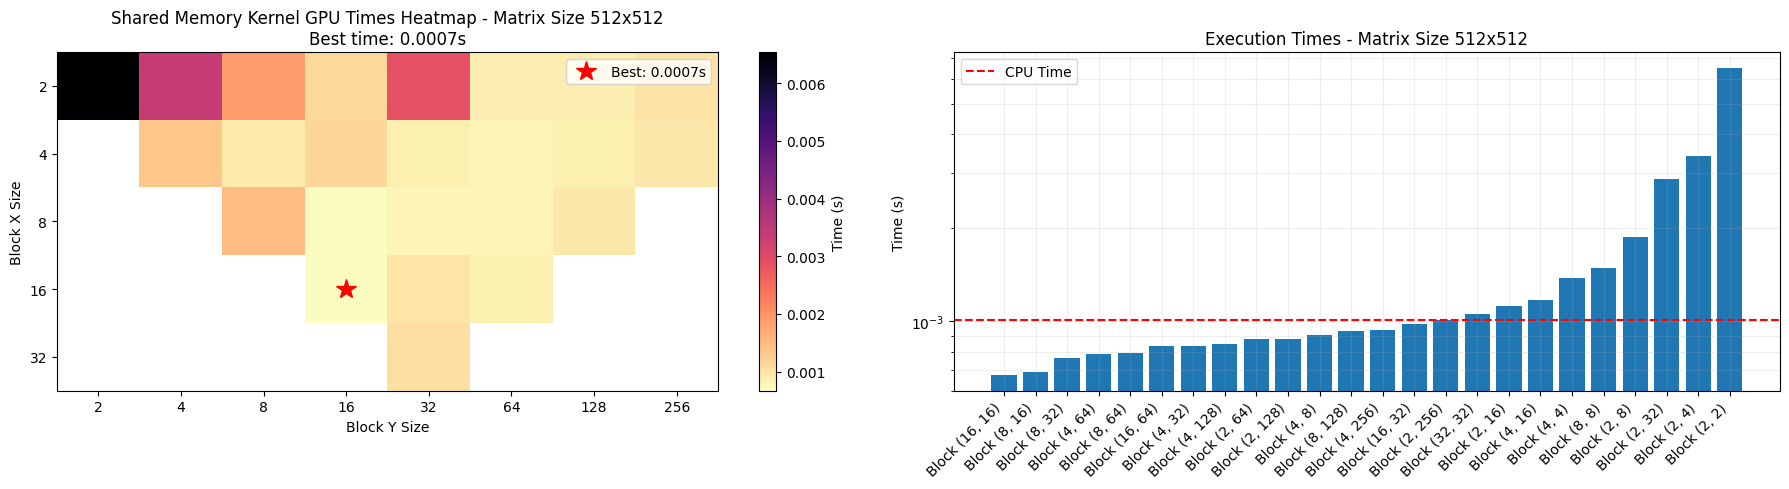

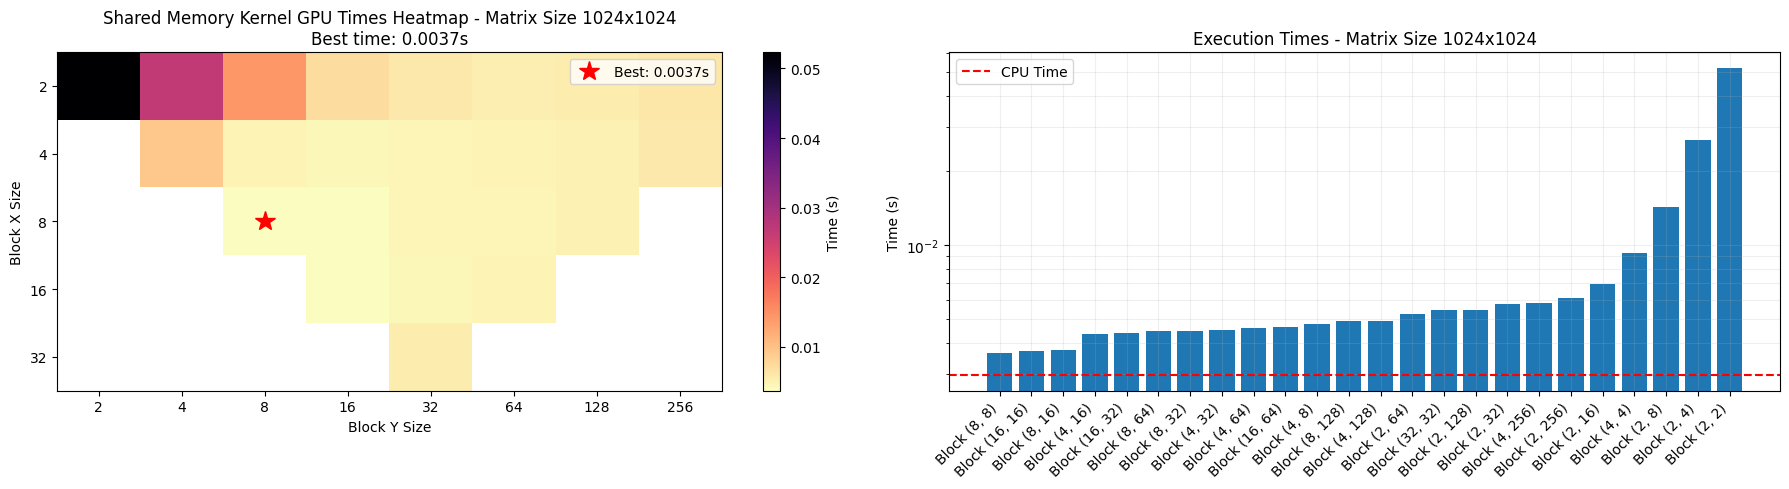

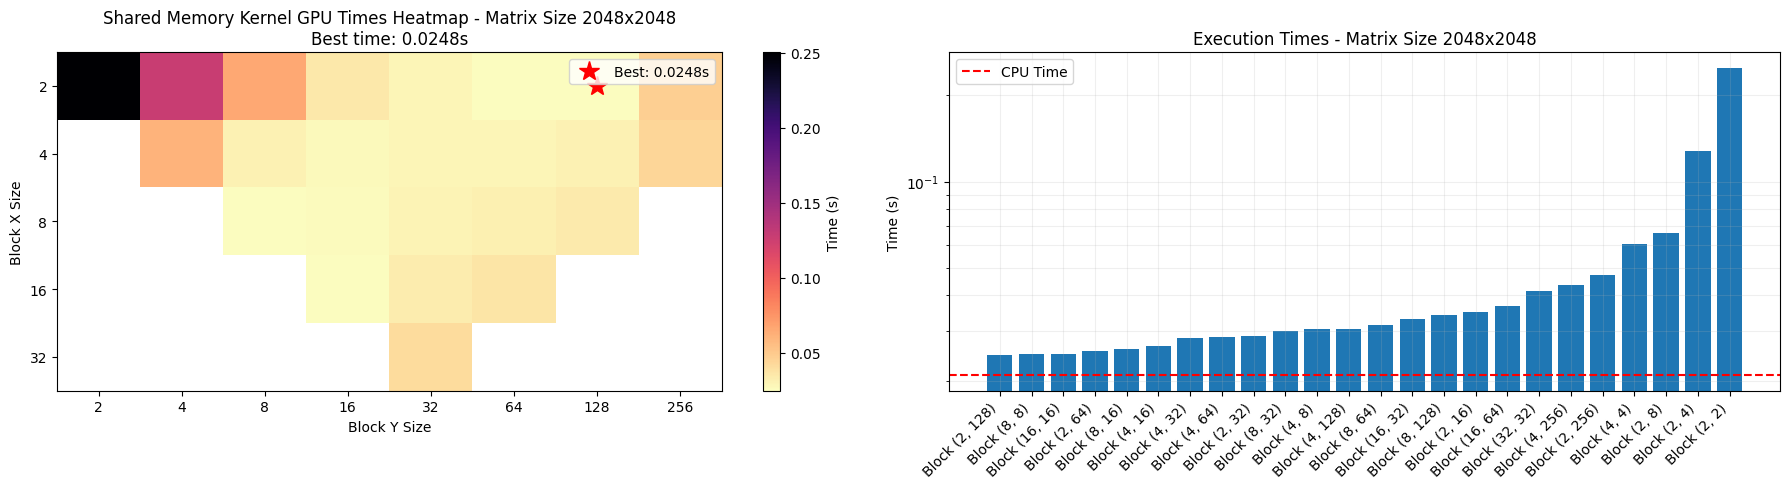

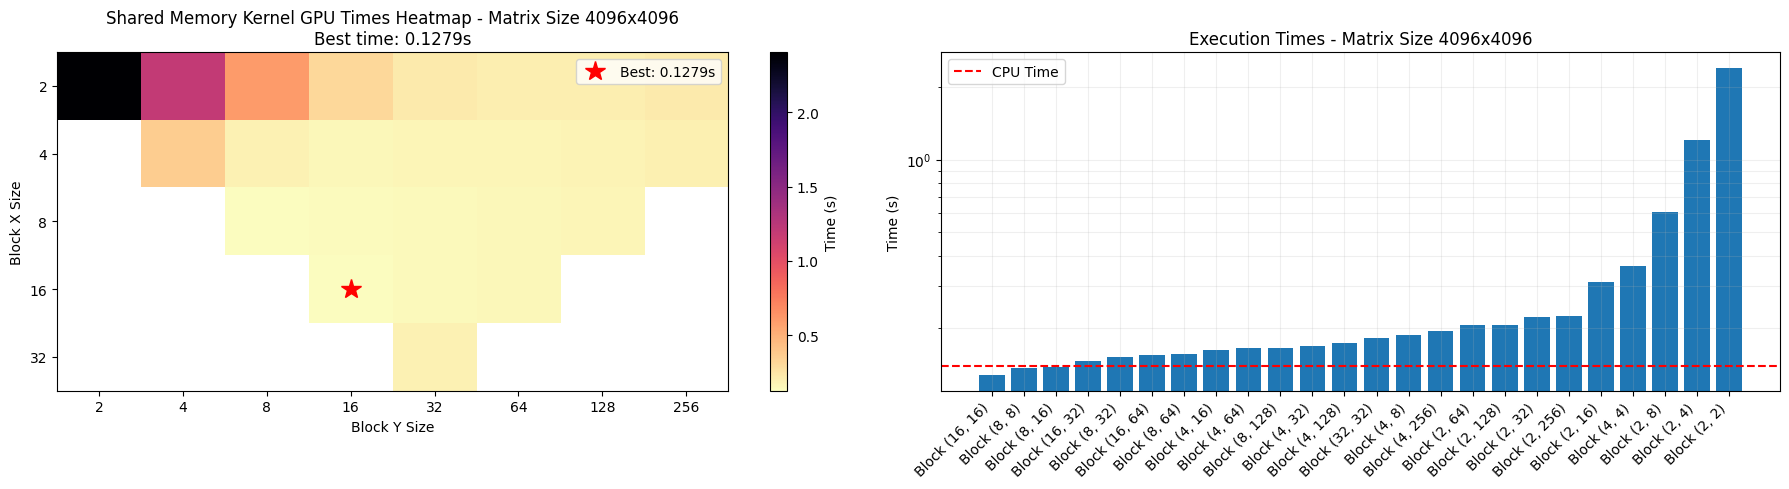

In [11]:
plot_results(results_shared, 'Shared Memory Kernel')

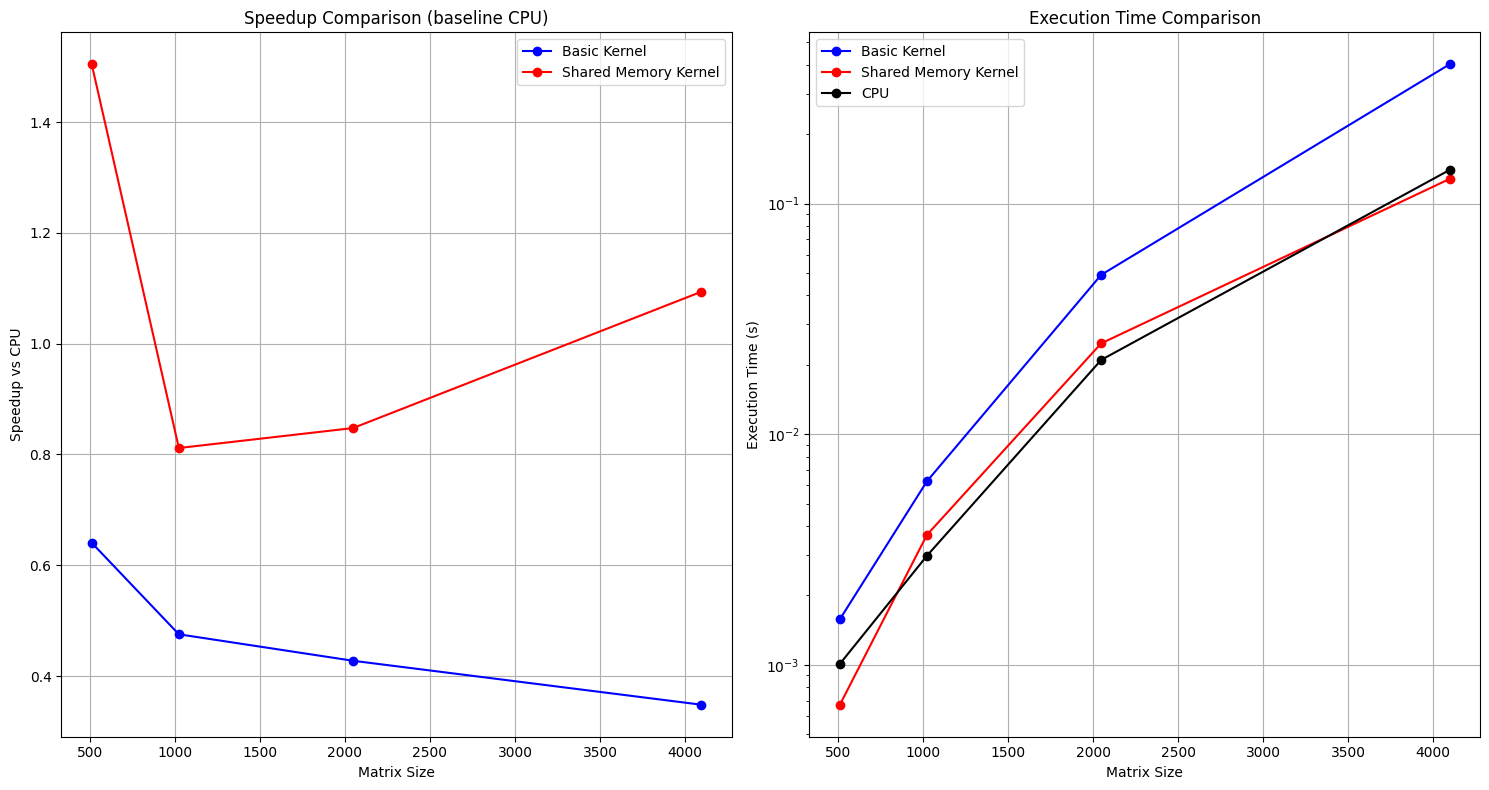


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0016    |    0.0007    | (16, 16)
    1024     |    0.0063    |    0.0037    | (8, 8)
    2048     |    0.0491    |    0.0248    | (2, 128)
    4096     |    0.4017    |    0.1279    | (16, 16)


In [12]:
def plot_kernel_comparison(best_times_list, labels, matrix_sizes):
    """
    Plot comparison of multiple kernel implementations
    
    Args:
        best_times_list: List of dictionaries containing best times for each implementation
        labels: List of labels for each implementation
        matrix_sizes: List of matrix sizes to plot
    """
    plt.figure(figsize=(15, 8))
    
    colors = ['b', 'r', 'g', 'c', 'm', 'y']  # Add more colors if needed
    
    # Plot speedups
    plt.subplot(1, 2, 1)
    for best_times, label, color in zip(best_times_list, labels, colors):
        plt.plot(matrix_sizes, [best_times[N]['speedup'] for N in matrix_sizes], 
                f'{color}-o', label=label)
    plt.xlabel('Matrix Size')
    plt.ylabel('Speedup vs CPU')
    plt.title('Speedup Comparison (baseline CPU)')
    plt.grid(True)
    plt.legend()

    # Plot execution times
    plt.subplot(1, 2, 2)
    for best_times, label, color in zip(best_times_list, labels, colors):
        plt.plot(matrix_sizes, [best_times[N]['gpu_time'] for N in matrix_sizes], 
                f'{color}-o', label=label)
    # Add CPU time from any of the implementations (they should all have same CPU time)
    plt.plot(matrix_sizes, [best_times_list[0][N]['cpu_time'] for N in matrix_sizes], 
            'k-o', label='CPU')
    plt.xlabel('Matrix Size')
    plt.ylabel('Execution Time (s)')
    plt.title('Execution Time Comparison')
    plt.yscale('log')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print detailed comparison
    print("\nDetailed Performance Comparison:")
    print("-" * 100)
    header = f"{'Matrix Size':^12} |"
    for label in labels:
        header += f" {label+' Time':^12} |"
    header += f" {'Best Block Size':^20}"
    print(header)
    print("-" * 100)

    for N in matrix_sizes:
        row = f"{N:^12} |"
        for best_times in best_times_list:
            row += f" {best_times[N]['gpu_time']:^12.4f} |"
        # Use block size from last implementation
        row += f" {best_times[N]['block_size']}"
        print(row)

# Get best times for each matrix size
best_times_basic = {}
best_times_shared = {}

for N in matrix_sizes:
    basic_N = [r for r in results_basic if r['matrix_size'] == N]
    shared_N = [r for r in results_shared if r['matrix_size'] == N]
    best_times_basic[N] = min(basic_N, key=lambda x: x['gpu_time'])
    best_times_shared[N] = min(shared_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared], 
                      ['Basic Kernel', 'Shared Memory Kernel'],
                      matrix_sizes)

Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

<font color='blue'>Antwort hier eingeben</font>

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

In [13]:
### BEGIN SOLUTION

def get_optimized_kernel_s_shared(threads_per_block):
    """
    Returns a tile-based GPU kernel that loads a chunk of s into shared memory
    to maximize data reuse. We also multiply s into U immediately.
    """
    blockDimX, blockDimY = threads_per_block

    @cuda.jit
    def tile_based_svd_kernel_s_shared(u, s, vt, C, k):
        """
        C[i, j] = sum_{r=0..k-1} (u[i, r] * s[r]) * vt[r, j]

        We'll read s[r] once per tile chunk into s_tile, then multiply into tileU.
        """
        row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

        # Out of bounds check
        if row >= C.shape[0] or col >= C.shape[1]:
            return

        # Shared memory arrays
        tileU  = cuda.shared.array(shape=(blockDimY, blockDimX), dtype=float32) 
        tileV  = cuda.shared.array(shape=(blockDimX, blockDimY), dtype=float32)  
        s_tile = cuda.shared.array(shape=(blockDimX,),    dtype=float32)  

        acc = 0.0
        tile_count = (k + blockDimX - 1) // blockDimX

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y

        for t in range(tile_count):
            k_base = t * blockDimX

            # 1) Load a chunk of s into shared memory
            s_index = k_base + tx
            if s_index < k:
                s_tile[tx] = s[s_index]
            else:
                s_tile[tx] = 0.0

            cuda.syncthreads()

            # 2) Load a tile of U (row, k_base + tx), multiply by s_tile[tx]
            if row < u.shape[0] and s_index < k:
                tileU[ty, tx] = u[row, s_index] * s_tile[tx]
            else:
                tileU[ty, tx] = 0.0

            # 3) Load a tile of V^T (k_base + ty, col)
            v_index = k_base + ty
            if v_index < vt.shape[0] and col < vt.shape[1]:
                tileV[tx, ty] = vt[v_index, col]
            else:
                tileV[tx, ty] = 0.0

            cuda.syncthreads()

            # 4) Accumulate partial dot-product across the tile
            for n in range(blockDimX):
                acc += tileU[ty, n] * tileV[n, tx]

            cuda.syncthreads()

        # Write final result
        C[row, col] = acc

    return tile_based_svd_kernel_s_shared

### END SOLUTION

In [14]:
results_optimized = benchmark_kernel(get_optimized_kernel_s_shared, matrix_sizes, block_configs, svd_components)

blockspergrid: (256, 256), threadsperblock: (2, 2)
Block size (2, 2): GPU time = 0.0116s, Speedup = 0.09x
blockspergrid: (256, 128), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.0060s, Speedup = 0.17x
blockspergrid: (256, 64), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0032s, Speedup = 0.32x
blockspergrid: (256, 32), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0022s, Speedup = 0.46x
blockspergrid: (256, 16), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0022s, Speedup = 0.47x
blockspergrid: (256, 8), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0025s, Speedup = 0.40x
blockspergrid: (256, 4), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0026s, Speedup = 0.38x
blockspergrid: (256, 2), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0029s, Speedup = 0.34x
blockspergrid: (128, 128), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0031s, Speedup = 0.33x
blockspergrid: (128, 64), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0018s, Speedup = 0.57x
blockspergrid: (128, 32), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0017s, Speedup = 0.60x
blockspergrid: (128, 16), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0016s, Speedup = 0.61x
blockspergrid: (128, 8), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0017s, Speedup = 0.58x
blockspergrid: (128, 4), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0020s, Speedup = 0.50x
blockspergrid: (128, 2), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0024s, Speedup = 0.42x
blockspergrid: (64, 64), threadsperblock: (8, 8)
Block size (8, 8): GPU time = 0.0017s, Speedup = 0.59x
blockspergrid: (64, 32), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0017s, Speedup = 0.60x
blockspergrid: (64, 16), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0019s, Speedup = 0.52x
blockspergrid: (64, 8), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0020s, Speedup = 0.50x
blockspergrid: (64, 4), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0023s, Speedup = 0.45x
blockspergrid: (32, 32), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0017s, Speedup = 0.60x
blockspergrid: (32, 16), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0018s, Speedup = 0.56x
blockspergrid: (32, 8), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0020s, Speedup = 0.50x
blockspergrid: (16, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 2048 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1048576 bytes


Block size (32, 32): GPU time = 0.0022s, Speedup = 0.46x
blockspergrid: (512, 512), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.0698s, Speedup = 0.04x
blockspergrid: (512, 256), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.0298s, Speedup = 0.10x
blockspergrid: (512, 128), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0151s, Speedup = 0.20x
blockspergrid: (512, 64), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0104s, Speedup = 0.29x
blockspergrid: (512, 32), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0099s, Speedup = 0.30x
blockspergrid: (512, 16), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0099s, Speedup = 0.30x
blockspergrid: (512, 8), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0104s, Speedup = 0.28x
blockspergrid: (512, 4), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0125s, Speedup = 0.24x
blockspergrid: (256, 256), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0232s, Speedup = 0.13x
blockspergrid: (256, 128), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0118s, Speedup = 0.25x
blockspergrid: (256, 64), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0117s, Speedup = 0.26x
blockspergrid: (256, 32), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0118s, Speedup = 0.25x
blockspergrid: (256, 16), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0120s, Speedup = 0.25x
blockspergrid: (256, 8), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0131s, Speedup = 0.23x
blockspergrid: (256, 4), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0156s, Speedup = 0.19x
blockspergrid: (128, 128), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0117s, Speedup = 0.25x
blockspergrid: (128, 64), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0117s, Speedup = 0.26x
blockspergrid: (128, 32), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0117s, Speedup = 0.25x
blockspergrid: (128, 16), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0125s, Speedup = 0.24x
blockspergrid: (128, 8), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0140s, Speedup = 0.21x
blockspergrid: (64, 64), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0120s, Speedup = 0.25x
blockspergrid: (64, 32), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0122s, Speedup = 0.24x
blockspergrid: (64, 16), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0135s, Speedup = 0.22x
blockspergrid: (32, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4096 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16384 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 2048 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cuda

Block size (32, 32): GPU time = 0.0132s, Speedup = 0.23x
blockspergrid: (1024, 1024), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.3987s, Speedup = 0.05x
blockspergrid: (1024, 512), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.1996s, Speedup = 0.11x
blockspergrid: (1024, 256), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.1045s, Speedup = 0.20x
blockspergrid: (1024, 128), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0702s, Speedup = 0.30x
blockspergrid: (1024, 64), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0715s, Speedup = 0.29x
blockspergrid: (1024, 32), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0707s, Speedup = 0.30x
blockspergrid: (1024, 16), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0737s, Speedup = 0.28x
blockspergrid: (1024, 8), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0809s, Speedup = 0.26x
blockspergrid: (512, 512), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0994s, Speedup = 0.21x
blockspergrid: (512, 256), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0502s, Speedup = 0.42x
blockspergrid: (512, 128), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0498s, Speedup = 0.42x
blockspergrid: (512, 64), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0498s, Speedup = 0.42x
blockspergrid: (512, 32), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0512s, Speedup = 0.41x
blockspergrid: (512, 16), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0556s, Speedup = 0.38x
blockspergrid: (512, 8), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0634s, Speedup = 0.33x
blockspergrid: (256, 256), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0500s, Speedup = 0.42x
blockspergrid: (256, 128), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0498s, Speedup = 0.42x
blockspergrid: (256, 64), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0502s, Speedup = 0.42x
blockspergrid: (256, 32), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0526s, Speedup = 0.40x
blockspergrid: (256, 16), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0593s, Speedup = 0.35x
blockspergrid: (128, 128), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0497s, Speedup = 0.42x
blockspergrid: (128, 64), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0505s, Speedup = 0.42x
blockspergrid: (128, 32), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0554s, Speedup = 0.38x
blockspergrid: (64, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8192 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes


Block size (32, 32): GPU time = 0.0557s, Speedup = 0.38x
blockspergrid: (2048, 2048), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 3.2090s, Speedup = 0.04x
blockspergrid: (2048, 1024), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 1.6075s, Speedup = 0.09x
blockspergrid: (2048, 512), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.8402s, Speedup = 0.17x
blockspergrid: (2048, 256), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.5755s, Speedup = 0.24x
blockspergrid: (2048, 128), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.5787s, Speedup = 0.24x
blockspergrid: (2048, 64), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.5739s, Speedup = 0.24x
blockspergrid: (2048, 32), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.5969s, Speedup = 0.23x
blockspergrid: (2048, 16), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.6576s, Speedup = 0.21x
blockspergrid: (1024, 1024), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.8089s, Speedup = 0.17x
blockspergrid: (1024, 512), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.4103s, Speedup = 0.34x
blockspergrid: (1024, 256), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.4041s, Speedup = 0.35x
blockspergrid: (1024, 128), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.4040s, Speedup = 0.35x
blockspergrid: (1024, 64), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.4153s, Speedup = 0.34x
blockspergrid: (1024, 32), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.4506s, Speedup = 0.31x
blockspergrid: (1024, 16), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.5024s, Speedup = 0.28x
blockspergrid: (512, 512), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.4029s, Speedup = 0.35x
blockspergrid: (512, 256), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.4011s, Speedup = 0.35x
blockspergrid: (512, 128), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.4031s, Speedup = 0.35x
blockspergrid: (512, 64), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.4224s, Speedup = 0.33x
blockspergrid: (512, 32), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.4752s, Speedup = 0.29x
blockspergrid: (256, 256), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.4024s, Speedup = 0.35x
blockspergrid: (256, 128), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.4084s, Speedup = 0.34x
blockspergrid: (256, 64), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.4481s, Speedup = 0.31x
blockspergrid: (128, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pen

Block size (32, 32): GPU time = 0.4393s, Speedup = 0.32x


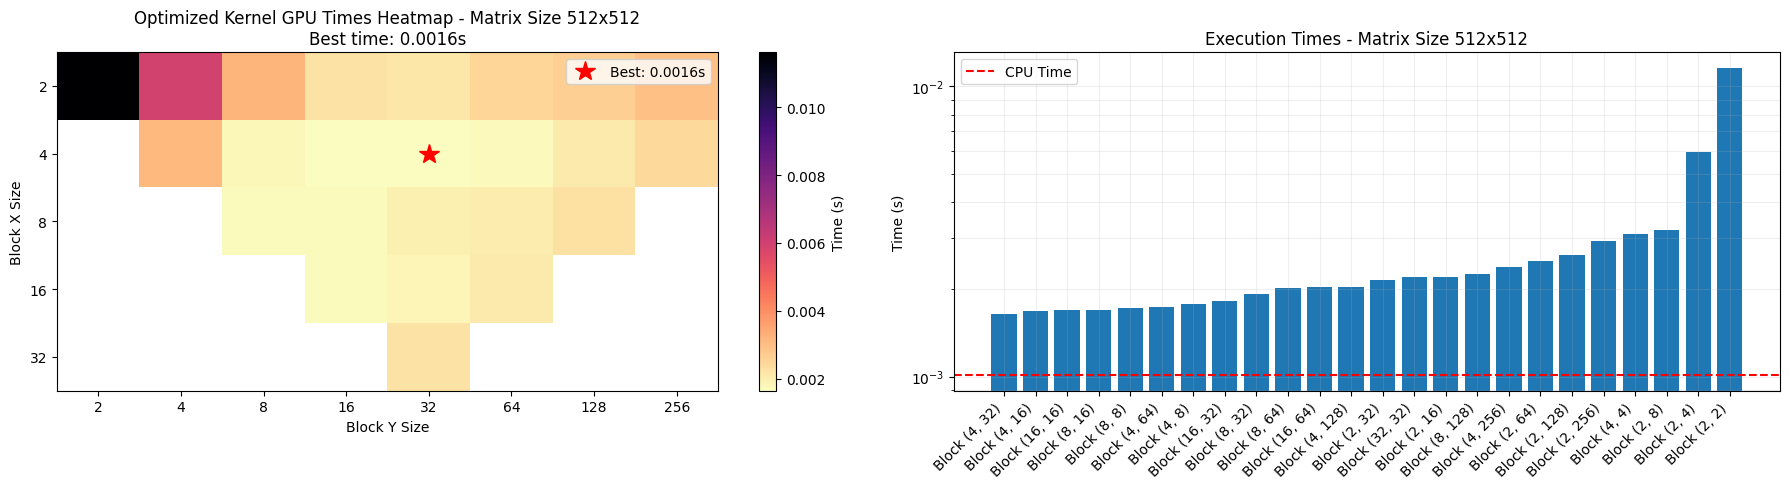

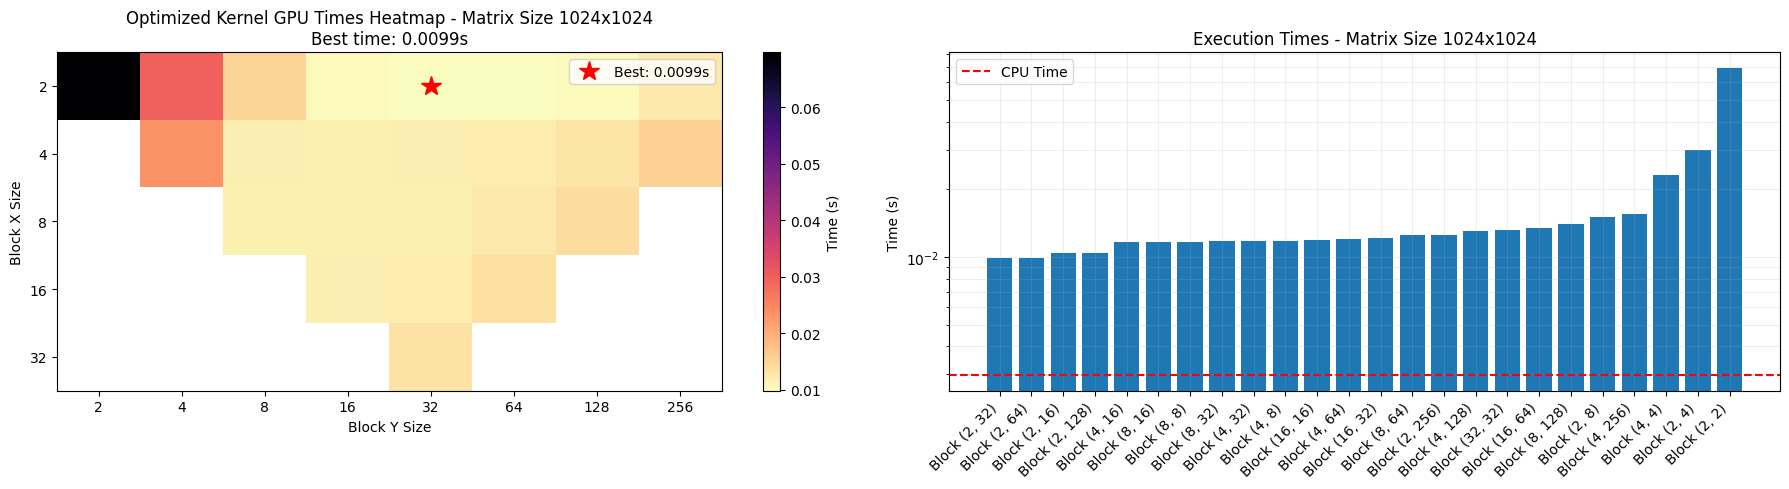

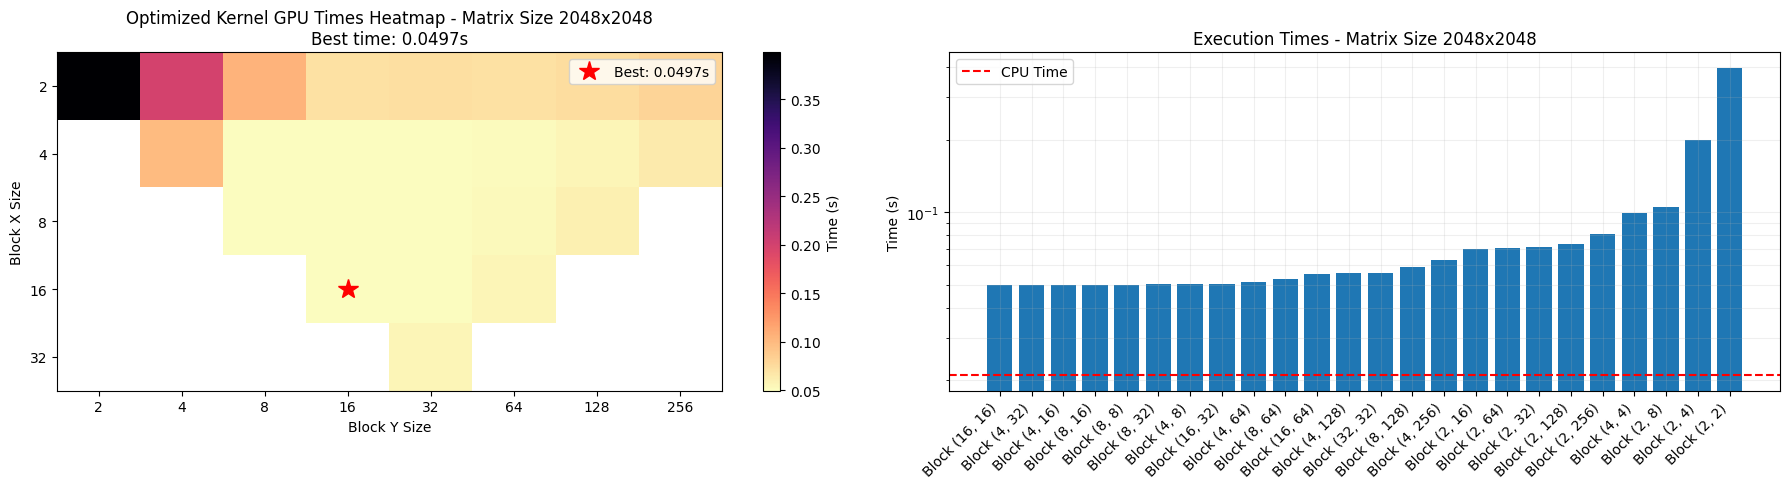

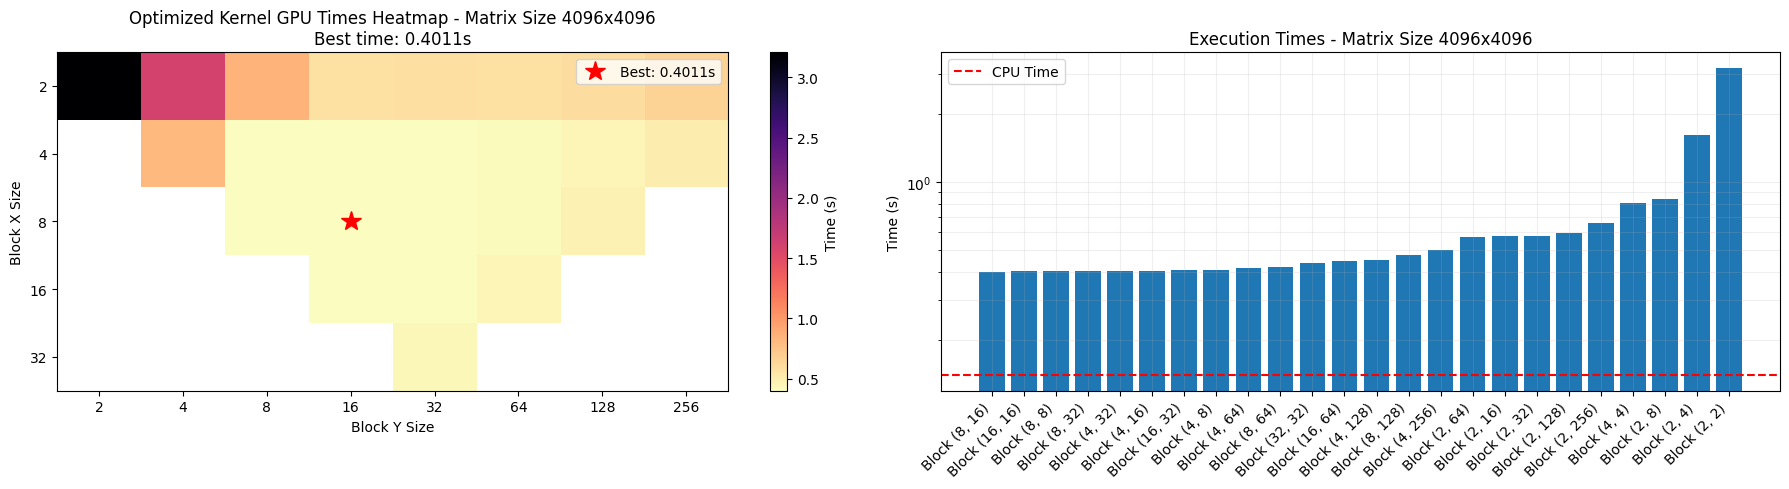

In [15]:
plot_results(results_optimized, 'Optimized Kernel')

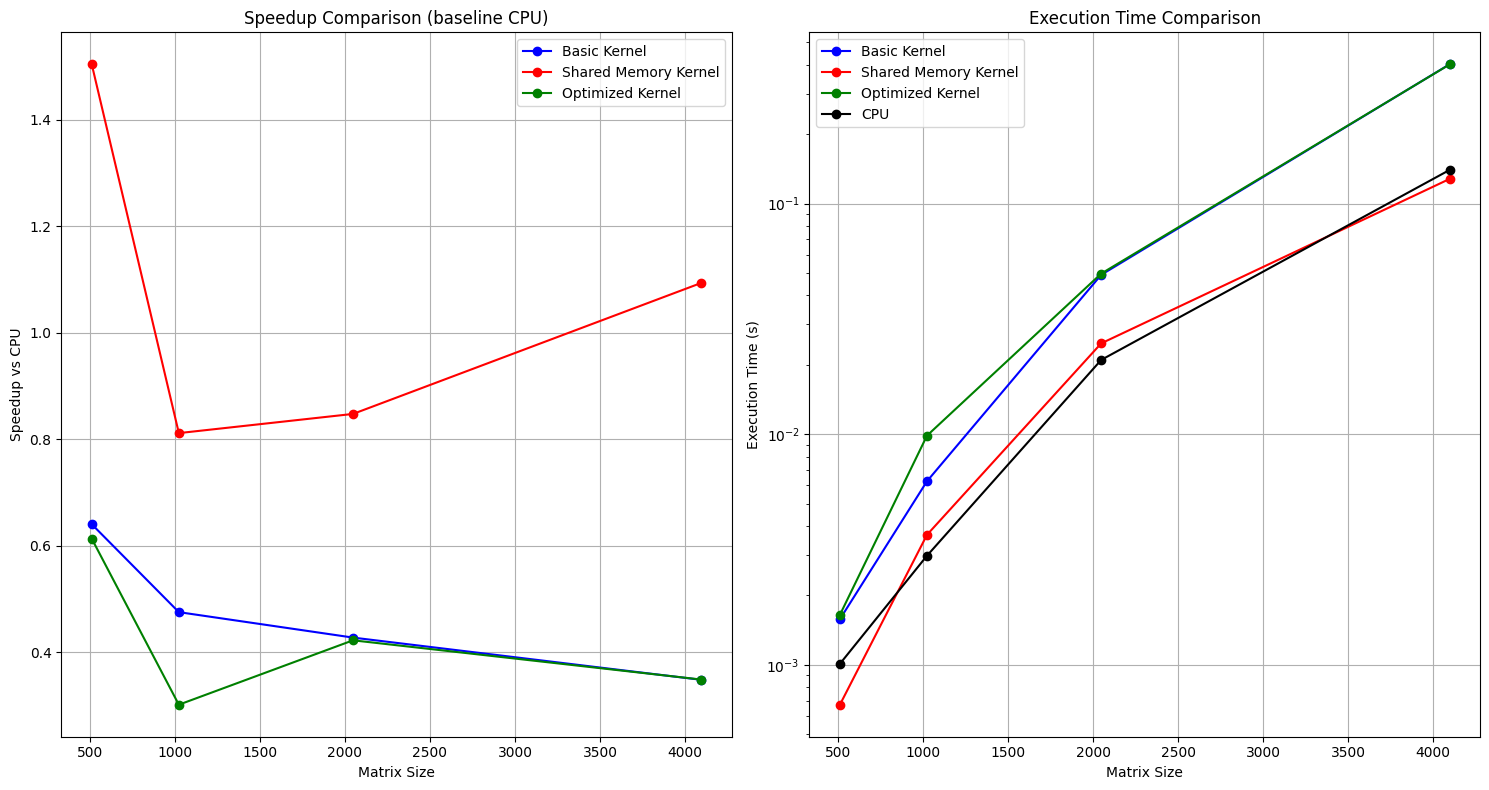


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Optimized Kernel Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0016    |    0.0007    |    0.0016    | (4, 32)
    1024     |    0.0063    |    0.0037    |    0.0099    | (2, 32)
    2048     |    0.0491    |    0.0248    |    0.0497    | (16, 16)
    4096     |    0.4017    |    0.1279    |    0.4011    | (8, 16)


In [16]:
best_times_optimized = {}
for N in matrix_sizes:
    optimized_N = [r for r in results_optimized if r['matrix_size'] == N]
    best_times_optimized[N] = min(optimized_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_optimized], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Optimized Kernel'],
                      matrix_sizes) 

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

<font color='blue'>Antwort hier eingeben inkl. Bild.</font>

##### Optimization

I started off with the optimized kernel from 5.2.3 and then used the ncu profiler to find the bottlenecks. This especially because the shared memory outperformed the original kernel by a lot, but my "optimized" kernel did not and actually performed worse than the base kernel. This definitely points to some issues with the kernel. 

See profiles/optimized_profile_original.ncu-rep 


The ncu profiles shows that 



In [17]:
def get_optimized_kernel_s_shared_fused(threads_per_block):
    blockDimX, blockDimY = threads_per_block

    @cuda.jit(fastmath=True)
    def tile_based_svd_kernel_s_shared(u, s, vt, C, k):
        row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
        col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

        if row >= C.shape[0] or col >= C.shape[1]:
            return

        tileU  = cuda.shared.array(shape=(blockDimY, blockDimX), dtype=float32)
        tileV  = cuda.shared.array(shape=(blockDimX, blockDimY), dtype=float32)
        s_tile = cuda.shared.array(shape=(blockDimX,), dtype=float32)

        # Force single-precision accumulator
        acc = float32(0.0)

        tile_count = (k + blockDimX - 1) // blockDimX
        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y

        for t in range(tile_count):
            k_base = t * blockDimX

            s_index = k_base + tx
            if s_index < k:
                s_tile[tx] = s[s_index]
            else:
                s_tile[tx] = float32(0.0)

            cuda.syncthreads()

            if row < u.shape[0] and s_index < k:
                tileU[ty, tx] = u[row, s_index] * s_tile[tx]
            else:
                tileU[ty, tx] = float32(0.0)

            v_index = k_base + ty
            if v_index < vt.shape[0] and col < vt.shape[1]:
                tileV[tx, ty] = vt[v_index, col]
            else:
                tileV[tx, ty] = float32(0.0)

            cuda.syncthreads()

            for n in range(blockDimX):
                acc += tileU[ty, n] * tileV[n, tx]

            cuda.syncthreads()

        C[row, col] = acc

    return tile_based_svd_kernel_s_shared

In [18]:

results_optimized_fused = benchmark_kernel(get_optimized_kernel_s_shared_fused, matrix_sizes, block_configs, svd_components)



blockspergrid: (256, 256), threadsperblock: (2, 2)
Block size (2, 2): GPU time = 0.0071s, Speedup = 0.14x
blockspergrid: (256, 128), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.0044s, Speedup = 0.23x
blockspergrid: (256, 64), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0029s, Speedup = 0.35x
blockspergrid: (256, 32), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0023s, Speedup = 0.45x
blockspergrid: (256, 16), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0021s, Speedup = 0.48x
blockspergrid: (256, 8), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0020s, Speedup = 0.50x
blockspergrid: (256, 4), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0020s, Speedup = 0.51x
blockspergrid: (256, 2), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0021s, Speedup = 0.49x
blockspergrid: (128, 128), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0014s, Speedup = 0.72x
blockspergrid: (128, 64), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0011s, Speedup = 0.95x
blockspergrid: (128, 32), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0017s, Speedup = 0.61x
blockspergrid: (128, 16), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0009s, Speedup = 1.10x
blockspergrid: (128, 8), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0009s, Speedup = 1.13x
blockspergrid: (128, 4), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0010s, Speedup = 1.03x
blockspergrid: (128, 2), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0011s, Speedup = 0.89x
blockspergrid: (64, 64), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0006s, Speedup = 1.77x
blockspergrid: (64, 32), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0008s, Speedup = 1.30x
blockspergrid: (64, 16), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0010s, Speedup = 1.00x
blockspergrid: (64, 8), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0006s, Speedup = 1.75x
blockspergrid: (64, 4), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0007s, Speedup = 1.44x
blockspergrid: (32, 32), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0006s, Speedup = 1.81x
blockspergrid: (32, 16), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0010s, Speedup = 1.03x
blockspergrid: (32, 8), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0023s, Speedup = 0.45x
blockspergrid: (16, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 8192 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16384 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.dri

Block size (32, 32): GPU time = 0.0007s, Speedup = 1.35x
blockspergrid: (512, 512), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.0552s, Speedup = 0.05x
blockspergrid: (512, 256), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.0242s, Speedup = 0.12x
blockspergrid: (512, 128), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0159s, Speedup = 0.19x
blockspergrid: (512, 64), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0116s, Speedup = 0.26x
blockspergrid: (512, 32), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0126s, Speedup = 0.24x
blockspergrid: (512, 16), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0105s, Speedup = 0.28x
blockspergrid: (512, 8), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0104s, Speedup = 0.29x
blockspergrid: (512, 4), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0104s, Speedup = 0.28x
blockspergrid: (256, 256), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0097s, Speedup = 0.31x
blockspergrid: (256, 128), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0070s, Speedup = 0.43x
blockspergrid: (256, 64), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0057s, Speedup = 0.52x
blockspergrid: (256, 32), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0057s, Speedup = 0.52x
blockspergrid: (256, 16), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0056s, Speedup = 0.53x
blockspergrid: (256, 8), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0057s, Speedup = 0.52x
blockspergrid: (256, 4), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0068s, Speedup = 0.44x
blockspergrid: (128, 128), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0035s, Speedup = 0.85x
blockspergrid: (128, 64), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0030s, Speedup = 1.01x
blockspergrid: (128, 32), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0032s, Speedup = 0.92x
blockspergrid: (128, 16), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0034s, Speedup = 0.89x
blockspergrid: (128, 8), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0039s, Speedup = 0.76x
blockspergrid: (64, 64), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0023s, Speedup = 1.32x
blockspergrid: (64, 32), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0027s, Speedup = 1.11x
blockspergrid: (64, 16), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0030s, Speedup = 0.98x
blockspergrid: (32, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4096 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes


Block size (32, 32): GPU time = 0.0026s, Speedup = 1.16x
blockspergrid: (1024, 1024), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.2662s, Speedup = 0.08x
blockspergrid: (1024, 512), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.1488s, Speedup = 0.14x
blockspergrid: (1024, 256), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0959s, Speedup = 0.22x
blockspergrid: (1024, 128), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0690s, Speedup = 0.30x
blockspergrid: (1024, 64), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0681s, Speedup = 0.31x
blockspergrid: (1024, 32), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0666s, Speedup = 0.32x
blockspergrid: (1024, 16), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0642s, Speedup = 0.33x
blockspergrid: (1024, 8), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0651s, Speedup = 0.32x
blockspergrid: (512, 512), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0463s, Speedup = 0.45x
blockspergrid: (512, 256), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0289s, Speedup = 0.73x
blockspergrid: (512, 128), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0250s, Speedup = 0.84x
blockspergrid: (512, 64), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0250s, Speedup = 0.84x
blockspergrid: (512, 32), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0239s, Speedup = 0.88x
blockspergrid: (512, 16), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0248s, Speedup = 0.85x
blockspergrid: (512, 8), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0285s, Speedup = 0.74x
blockspergrid: (256, 256), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0191s, Speedup = 1.10x
blockspergrid: (256, 128), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0197s, Speedup = 1.07x
blockspergrid: (256, 64), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0244s, Speedup = 0.86x
blockspergrid: (256, 32), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0247s, Speedup = 0.85x
blockspergrid: (256, 16), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0285s, Speedup = 0.74x
blockspergrid: (128, 128), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0168s, Speedup = 1.25x
blockspergrid: (128, 64), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0196s, Speedup = 1.07x
blockspergrid: (128, 32), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0210s, Speedup = 1.00x
blockspergrid: (64, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:add pen

Block size (32, 32): GPU time = 0.0189s, Speedup = 1.11x
blockspergrid: (2048, 2048), threadsperblock: (2, 2)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 2.1294s, Speedup = 0.07x
blockspergrid: (2048, 1024), threadsperblock: (2, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 1.1864s, Speedup = 0.12x
blockspergrid: (2048, 512), threadsperblock: (2, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.7692s, Speedup = 0.18x
blockspergrid: (2048, 256), threadsperblock: (2, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.5614s, Speedup = 0.25x
blockspergrid: (2048, 128), threadsperblock: (2, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.5543s, Speedup = 0.25x
blockspergrid: (2048, 64), threadsperblock: (2, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.5372s, Speedup = 0.26x
blockspergrid: (2048, 32), threadsperblock: (2, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.5265s, Speedup = 0.27x
blockspergrid: (2048, 16), threadsperblock: (2, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.5262s, Speedup = 0.27x
blockspergrid: (1024, 1024), threadsperblock: (4, 4)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.3762s, Speedup = 0.37x
blockspergrid: (1024, 512), threadsperblock: (4, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.2330s, Speedup = 0.60x
blockspergrid: (1024, 256), threadsperblock: (4, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.2107s, Speedup = 0.66x
blockspergrid: (1024, 128), threadsperblock: (4, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.2074s, Speedup = 0.67x
blockspergrid: (1024, 64), threadsperblock: (4, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.2000s, Speedup = 0.70x
blockspergrid: (1024, 32), threadsperblock: (4, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.2026s, Speedup = 0.69x
blockspergrid: (1024, 16), threadsperblock: (4, 256)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.2284s, Speedup = 0.61x
blockspergrid: (512, 512), threadsperblock: (8, 8)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.1118s, Speedup = 1.25x
blockspergrid: (512, 256), threadsperblock: (8, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.1103s, Speedup = 1.27x
blockspergrid: (512, 128), threadsperblock: (8, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.1152s, Speedup = 1.21x
blockspergrid: (512, 64), threadsperblock: (8, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.1147s, Speedup = 1.22x
blockspergrid: (512, 32), threadsperblock: (8, 128)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.1257s, Speedup = 1.11x
blockspergrid: (256, 256), threadsperblock: (16, 16)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0810s, Speedup = 1.73x
blockspergrid: (256, 128), threadsperblock: (16, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0891s, Speedup = 1.57x
blockspergrid: (256, 64), threadsperblock: (16, 64)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0936s, Speedup = 1.49x
blockspergrid: (128, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16384 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (32, 32): GPU time = 0.0825s, Speedup = 1.70x


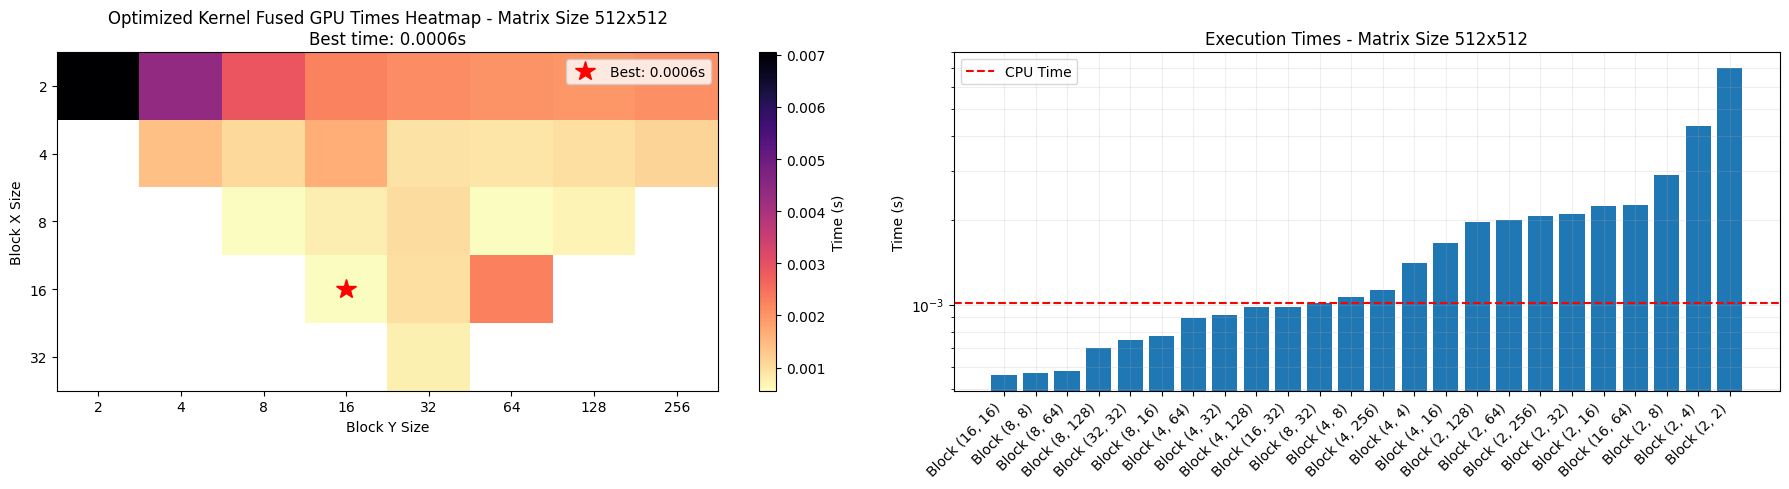

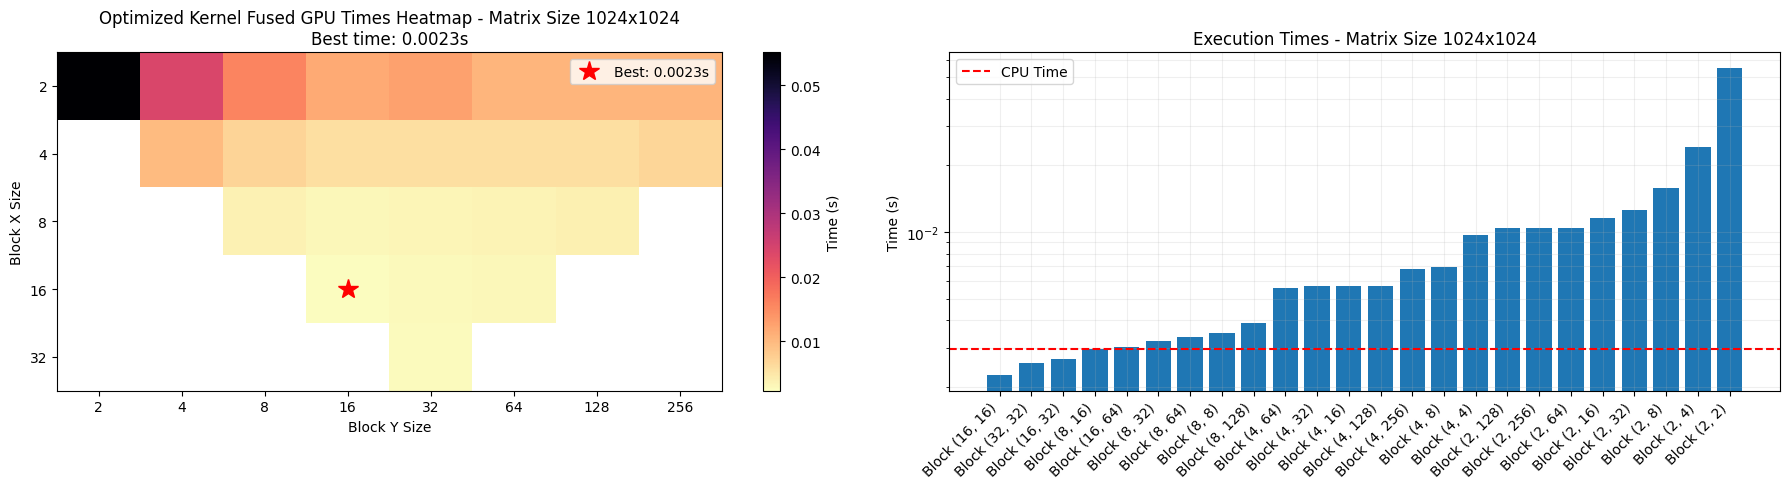

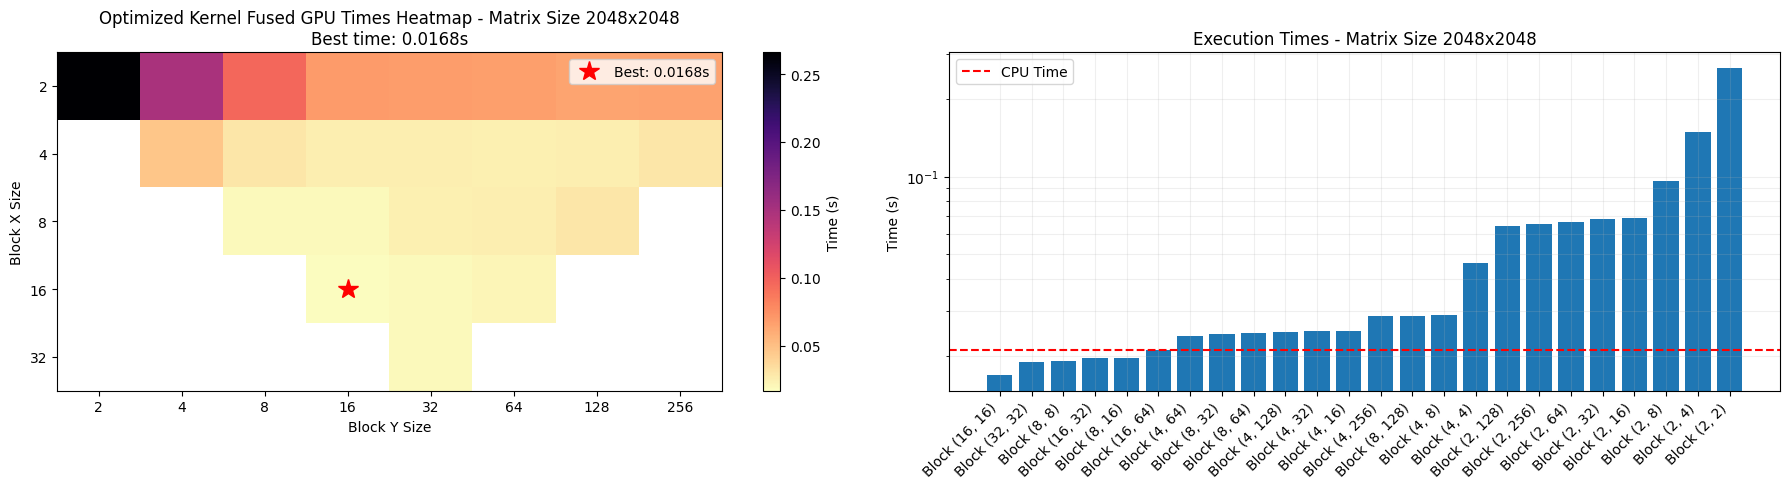

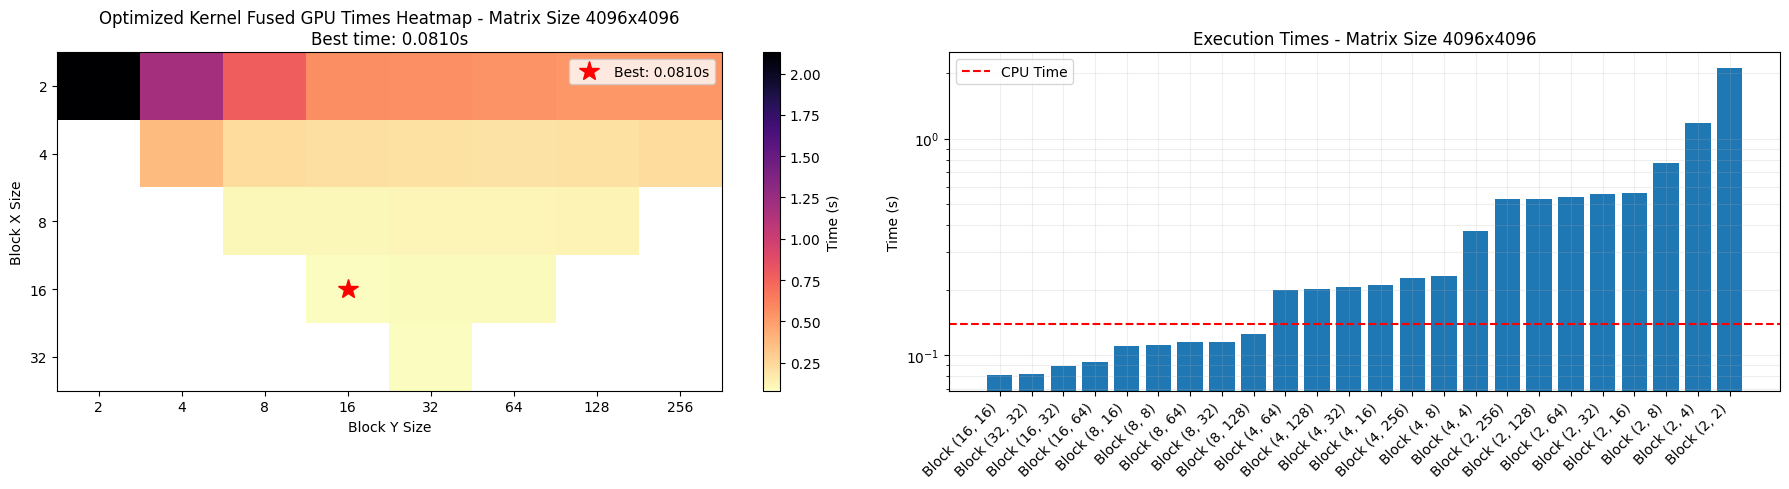

In [19]:
plot_results(results_optimized_fused, 'Optimized Kernel Fused')

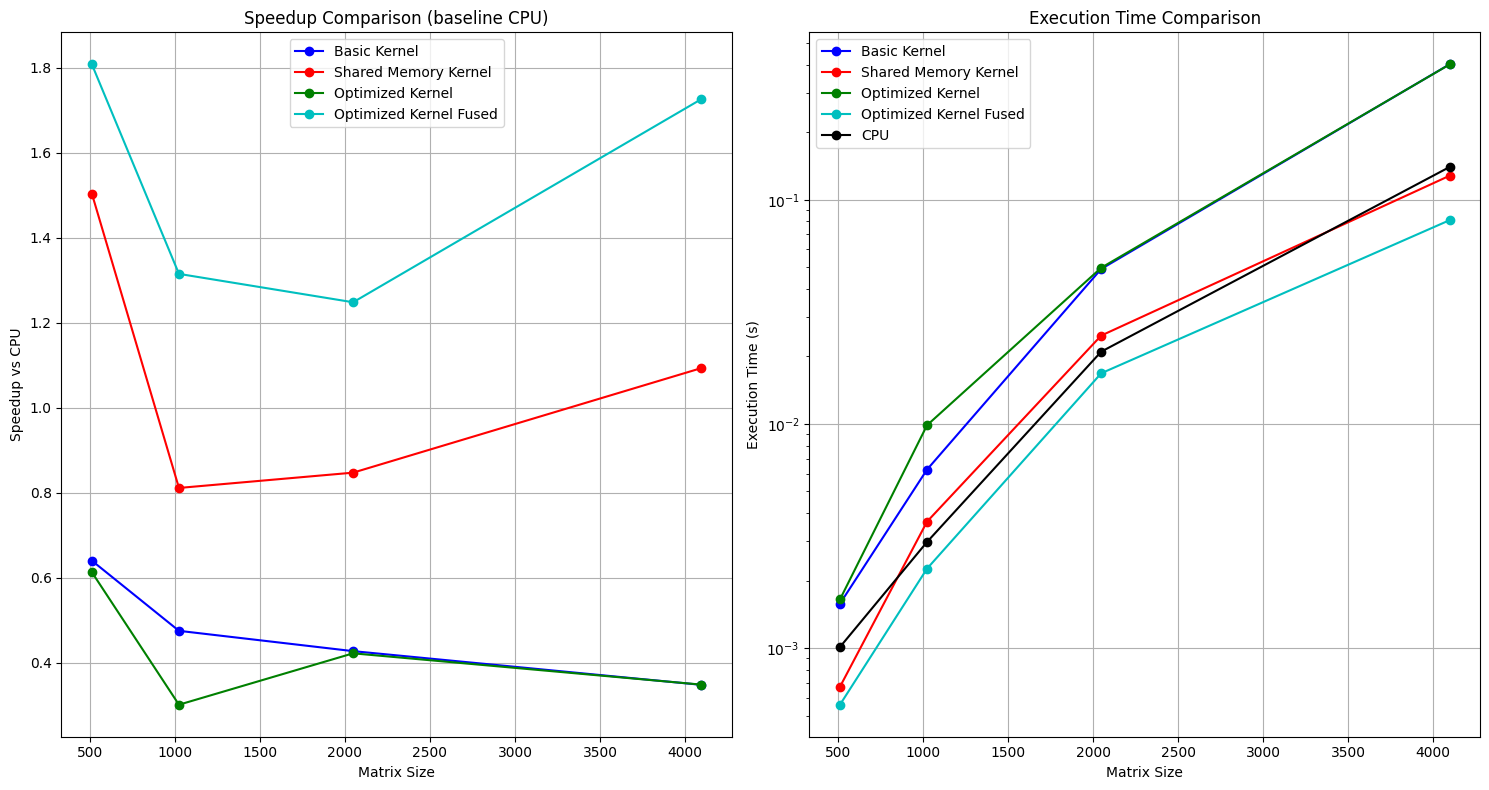


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Optimized Kernel Time | Optimized Kernel Fused Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0016    |    0.0007    |    0.0016    |    0.0006    | (16, 16)
    1024     |    0.0063    |    0.0037    |    0.0099    |    0.0023    | (16, 16)
    2048     |    0.0491    |    0.0248    |    0.0497    |    0.0168    | (16, 16)
    4096     |    0.4017    |    0.1279    |    0.4011    |    0.0810    | (16, 16)


In [20]:
best_times_optimized_fused = {}
for N in matrix_sizes:
    optimized_fused_N = [r for r in results_optimized_fused if r['matrix_size'] == N]
    best_times_optimized_fused[N] = min(optimized_fused_N, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_optimized, best_times_optimized_fused], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Optimized Kernel', 'Optimized Kernel Fused'],
                      matrix_sizes) 

In [21]:
def get_optimized_kernel_padding(threads_per_block):

    blockDimX, blockDimY = threads_per_block

    @cuda.jit(fastmath=True)
    def tile_based_svd_kernel_s_shared(u, s, vt, C, k):
        # Access dynamic shared memory as a 1D buffer
        shared_mem = cuda.shared.array(0, float32)

        # Precompute chunk sizes
        tileU_size  = blockDimY * (blockDimX + 1)  # +1 to reduce bank conflicts
        tileV_size  = blockDimX * (blockDimY + 1)
        s_tile_size = blockDimX
        total_size  = tileU_size + tileV_size + s_tile_size

        # Partition the 1D buffer
        tileU_1d  = shared_mem[0 : tileU_size]
        tileV_1d  = shared_mem[tileU_size : tileU_size + tileV_size]
        s_tile_1d = shared_mem[tileU_size + tileV_size : total_size]

        # Map thread to global row/col
        row = cuda.blockIdx.y * blockDimY + cuda.threadIdx.y
        col = cuda.blockIdx.x * blockDimX + cuda.threadIdx.x

        if row >= C.shape[0] or col >= C.shape[1]:
            return

        # Accumulator
        acc = float32(0.0)
        tile_count = (k + blockDimX - 1) // blockDimX

        tx = cuda.threadIdx.x
        ty = cuda.threadIdx.y

        for t in range(tile_count):
            k_base = t * blockDimX
            s_idx  = k_base + tx

            # 1) Load s_tile
            if s_idx < k:
                s_tile_1d[tx] = s[s_idx]
            else:
                s_tile_1d[tx] = float32(0.0)

            cuda.syncthreads()

            # 2) tileU: row-based => ty * (blockDimX+1) + tx
            #    Multiply U by s_tile
            u_index_1d = ty * (blockDimX + 1) + tx
            if (row < u.shape[0]) and (s_idx < k):
                val_s = s_tile_1d[tx]
                tileU_1d[u_index_1d] = u[row, s_idx] * val_s
            else:
                tileU_1d[u_index_1d] = float32(0.0)

            # 3) tileV: col-based => tx * (blockDimY+1) + ty
            v_index_1d = tx * (blockDimY + 1) + ty
            v_idx = k_base + ty
            if v_idx < vt.shape[0] and col < vt.shape[1]:
                tileV_1d[v_index_1d] = vt[v_idx, col]
            else:
                tileV_1d[v_index_1d] = float32(0.0)

            cuda.syncthreads()

            # 4) Dot product across blockDimX
            #    tileU_1d[ty*(blockDimX+1) + n] * tileV_1d[n*(blockDimY+1) + tx]
            for n in range(blockDimX):
                acc += tileU_1d[ty * (blockDimX + 1) + n] * tileV_1d[n * (blockDimY + 1) + tx]

            cuda.syncthreads()

        C[row, col] = acc

    return tile_based_svd_kernel_s_shared


In [22]:
results_optimized_fused_padding = []

# we can't use the base benchmark kernel because we require 
for N in matrix_sizes:
    # Get precomputed components
    u = svd_components[N]['u']
    s = svd_components[N]['s'] 
    vt = svd_components[N]['vt']
    k = svd_components[N]['k']

    # Allocate device memory
    u_device = cuda.to_device(u)
    s_device = cuda.to_device(s)
    vt_device = cuda.to_device(vt)
    C_device = cuda.device_array((N, N), dtype=np.float32)

    for block_size in block_configs:
        bx, by = block_size
        blockspergrid_x = math.ceil(N / bx)
        blockspergrid_y = math.ceil(N / by)
        blockspergrid = (blockspergrid_x, blockspergrid_y)
        print(f"blockspergrid: {blockspergrid}, threadsperblock: {threadsperblock}")
        
        # Get kernel
        kernel = get_optimized_kernel_padding((bx, by))

        # Compute dynamic shared memory usage
        tileU_size  = by*(bx+1)
        tileV_size  = bx*(by+1)
        s_tile_size = bx
        total_floats = tileU_size + tileV_size + s_tile_size
        shared_mem_bytes = total_floats * 4  # 4 bytes per float32

        # Grid, block
        gridX = math.ceil(N / bx)
        gridY = math.ceil(N / by)
        grid_dims = (gridX, gridY)
        block_dims= (bx, by)

        # Warm-up
        # we need to pass the shared memory size to the kernel to avoid shape errors
        kernel[grid_dims, block_dims, 0, shared_mem_bytes](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()

        # Time with CUDA events
        start_event = cuda.event()
        stop_event  = cuda.event()

        start_event.record()
        kernel[grid_dims, block_dims, 0, shared_mem_bytes](u_device, s_device, vt_device, C_device, k)
        cuda.synchronize()
        stop_event.record()

        gpu_time_ms = cuda.event_elapsed_time(start_event, stop_event)
        gpu_time = gpu_time_ms / 1000

        # Copy result back to host
        C_gpu = C_device.copy_to_host()
        
        speedup = svd_components[N]['cpu_time'] / gpu_time
        
        results_optimized_fused_padding.append({
            'kernel': 'shared',
            'matrix_size': N,
            'block_size': block_size,
            'cpu_time': svd_components[N]['cpu_time'],
            'gpu_time': gpu_time,
            'speedup': speedup,
        })
        
        print(f"Block size {block_size}: GPU time = {gpu_time:.4f}s, Speedup = {speedup:.2f}x")
        
    # Clean up device memory
    del u_device, s_device, vt_device, C_device
    


blockspergrid: (256, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.0071s, Speedup = 0.14x
blockspergrid: (256, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.0064s, Speedup = 0.16x
blockspergrid: (256, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0029s, Speedup = 0.35x
blockspergrid: (256, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0023s, Speedup = 0.44x
blockspergrid: (256, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0021s, Speedup = 0.48x
blockspergrid: (256, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0020s, Speedup = 0.50x
blockspergrid: (256, 4), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0020s, Speedup = 0.51x
blockspergrid: (256, 2), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0022s, Speedup = 0.46x
blockspergrid: (128, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0015s, Speedup = 0.68x
blockspergrid: (128, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0010s, Speedup = 0.97x
blockspergrid: (128, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0009s, Speedup = 1.10x
blockspergrid: (128, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0009s, Speedup = 1.09x
blockspergrid: (128, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0020s, Speedup = 0.50x
blockspergrid: (128, 4), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0014s, Speedup = 0.71x
blockspergrid: (128, 2), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0012s, Speedup = 0.85x
blockspergrid: (64, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0007s, Speedup = 1.49x
blockspergrid: (64, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0006s, Speedup = 1.77x
blockspergrid: (64, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0006s, Speedup = 1.67x
blockspergrid: (64, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0018s, Speedup = 0.55x
blockspergrid: (64, 4), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0013s, Speedup = 0.79x
blockspergrid: (32, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0008s, Speedup = 1.27x
blockspergrid: (32, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0005s, Speedup = 1.85x
blockspergrid: (32, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0007s, Speedup = 1.50x
blockspergrid: (16, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:add pend

Block size (32, 32): GPU time = 0.0010s, Speedup = 1.04x
blockspergrid: (512, 512), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.0553s, Speedup = 0.05x
blockspergrid: (512, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.0242s, Speedup = 0.12x
blockspergrid: (512, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0158s, Speedup = 0.19x
blockspergrid: (512, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0121s, Speedup = 0.25x
blockspergrid: (512, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0112s, Speedup = 0.26x
blockspergrid: (512, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0107s, Speedup = 0.28x
blockspergrid: (512, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0120s, Speedup = 0.25x
blockspergrid: (512, 4), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0146s, Speedup = 0.20x
blockspergrid: (256, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0097s, Speedup = 0.31x
blockspergrid: (256, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0067s, Speedup = 0.45x
blockspergrid: (256, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0060s, Speedup = 0.50x
blockspergrid: (256, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0062s, Speedup = 0.48x
blockspergrid: (256, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0057s, Speedup = 0.52x
blockspergrid: (256, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0059s, Speedup = 0.50x
blockspergrid: (256, 4), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0070s, Speedup = 0.43x
blockspergrid: (128, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0031s, Speedup = 0.95x
blockspergrid: (128, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0030s, Speedup = 1.00x
blockspergrid: (128, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0035s, Speedup = 0.84x
blockspergrid: (128, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0031s, Speedup = 0.97x
blockspergrid: (128, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0037s, Speedup = 0.81x
blockspergrid: (64, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0021s, Speedup = 1.42x
blockspergrid: (64, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0031s, Speedup = 0.97x
blockspergrid: (64, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0034s, Speedup = 0.87x
blockspergrid: (32, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4096 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16384 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 2048 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1048576 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numb

Block size (32, 32): GPU time = 0.0034s, Speedup = 0.89x
blockspergrid: (1024, 1024), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 0.2653s, Speedup = 0.08x
blockspergrid: (1024, 512), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 0.1491s, Speedup = 0.14x
blockspergrid: (1024, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.0960s, Speedup = 0.22x
blockspergrid: (1024, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.0714s, Speedup = 0.29x
blockspergrid: (1024, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.0696s, Speedup = 0.30x
blockspergrid: (1024, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.0678s, Speedup = 0.31x
blockspergrid: (1024, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.0669s, Speedup = 0.31x
blockspergrid: (1024, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.0664s, Speedup = 0.32x
blockspergrid: (512, 512), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.0449s, Speedup = 0.47x
blockspergrid: (512, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.0291s, Speedup = 0.72x
blockspergrid: (512, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.0255s, Speedup = 0.82x
blockspergrid: (512, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.0251s, Speedup = 0.84x
blockspergrid: (512, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.0247s, Speedup = 0.85x
blockspergrid: (512, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.0261s, Speedup = 0.80x
blockspergrid: (512, 8), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.0289s, Speedup = 0.73x
blockspergrid: (256, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.0178s, Speedup = 1.18x
blockspergrid: (256, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.0216s, Speedup = 0.97x
blockspergrid: (256, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.0227s, Speedup = 0.92x
blockspergrid: (256, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.0229s, Speedup = 0.92x
blockspergrid: (256, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.0269s, Speedup = 0.78x
blockspergrid: (128, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0157s, Speedup = 1.34x
blockspergrid: (128, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0166s, Speedup = 1.27x
blockspergrid: (128, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0173s, Speedup = 1.22x
blockspergrid: (64, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 8192 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16777216 bytes


Block size (32, 32): GPU time = 0.0246s, Speedup = 0.85x
blockspergrid: (2048, 2048), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 2): GPU time = 2.1254s, Speedup = 0.07x
blockspergrid: (2048, 1024), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 4): GPU time = 1.1857s, Speedup = 0.12x
blockspergrid: (2048, 512), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 8): GPU time = 0.7691s, Speedup = 0.18x
blockspergrid: (2048, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 16): GPU time = 0.5815s, Speedup = 0.24x
blockspergrid: (2048, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 32): GPU time = 0.5665s, Speedup = 0.25x
blockspergrid: (2048, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 64): GPU time = 0.5475s, Speedup = 0.26x
blockspergrid: (2048, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 128): GPU time = 0.5347s, Speedup = 0.26x
blockspergrid: (2048, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (2, 256): GPU time = 0.5352s, Speedup = 0.26x
blockspergrid: (1024, 1024), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 4): GPU time = 0.3752s, Speedup = 0.37x
blockspergrid: (1024, 512), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 8): GPU time = 0.2425s, Speedup = 0.58x
blockspergrid: (1024, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 16): GPU time = 0.2162s, Speedup = 0.65x
blockspergrid: (1024, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 32): GPU time = 0.2119s, Speedup = 0.66x
blockspergrid: (1024, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 64): GPU time = 0.2039s, Speedup = 0.69x
blockspergrid: (1024, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 128): GPU time = 0.2088s, Speedup = 0.67x
blockspergrid: (1024, 16), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (4, 256): GPU time = 0.2348s, Speedup = 0.60x
blockspergrid: (512, 512), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 8): GPU time = 0.1157s, Speedup = 1.21x
blockspergrid: (512, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 16): GPU time = 0.1084s, Speedup = 1.29x
blockspergrid: (512, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 32): GPU time = 0.1081s, Speedup = 1.29x
blockspergrid: (512, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 64): GPU time = 0.1081s, Speedup = 1.29x
blockspergrid: (512, 32), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (8, 128): GPU time = 0.1193s, Speedup = 1.17x
blockspergrid: (256, 256), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 16): GPU time = 0.0780s, Speedup = 1.79x
blockspergrid: (256, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 32): GPU time = 0.0781s, Speedup = 1.79x
blockspergrid: (256, 64), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Block size (16, 64): GPU time = 0.0806s, Speedup = 1.74x
blockspergrid: (128, 128), threadsperblock: (32, 32)


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:add pen

Block size (32, 32): GPU time = 0.1214s, Speedup = 1.15x


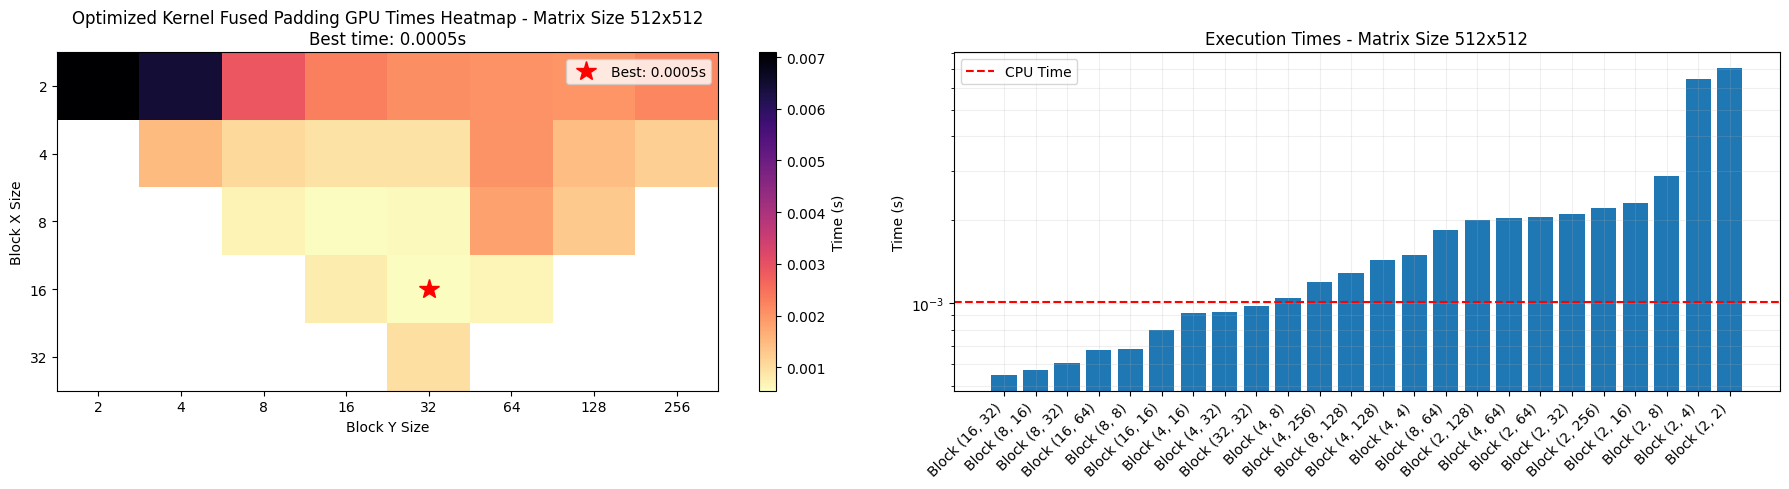

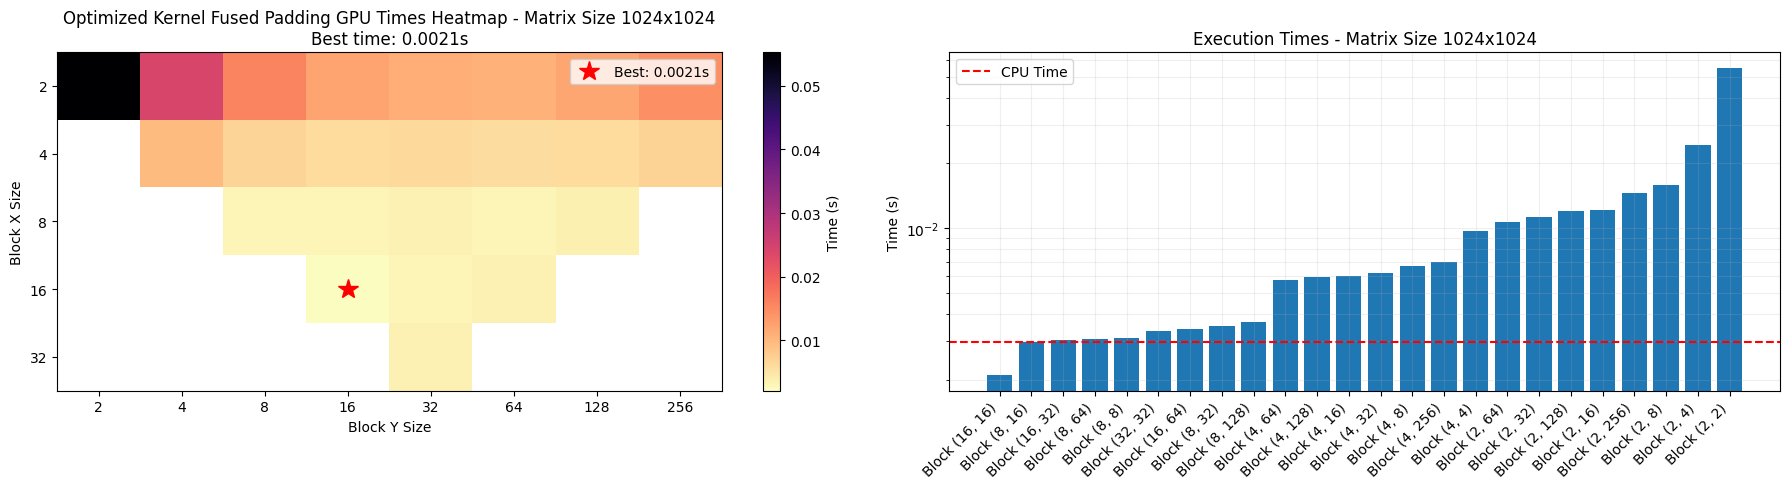

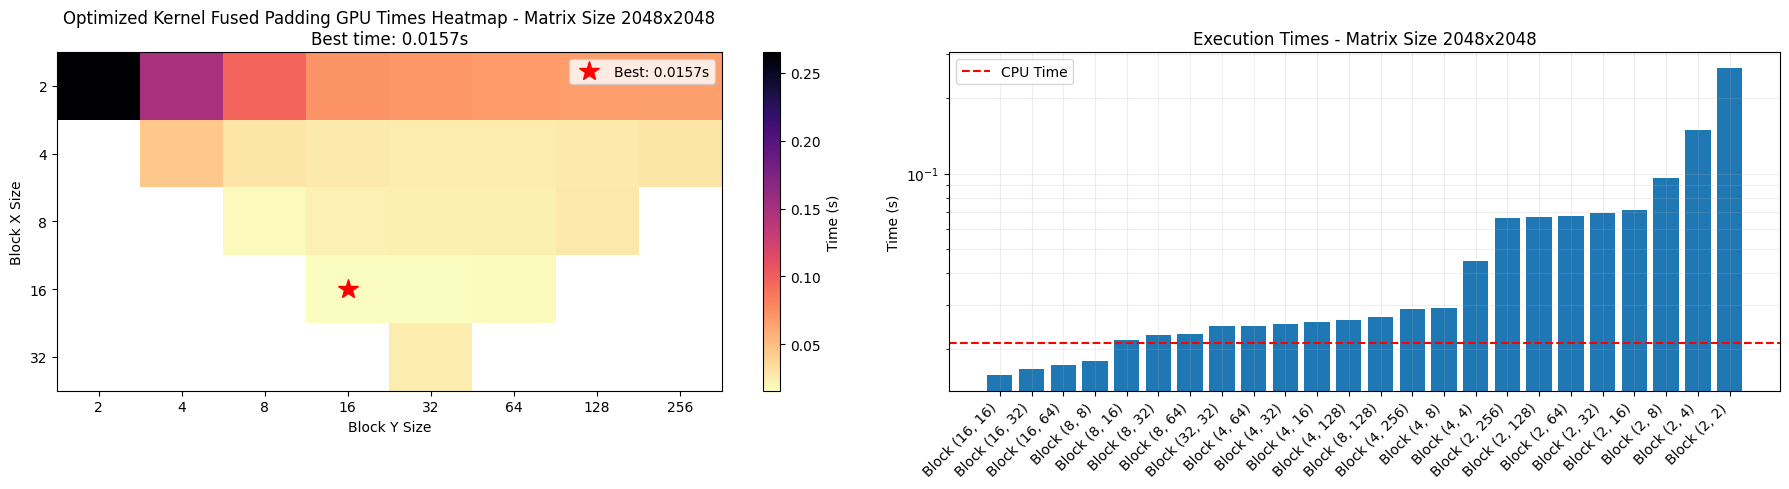

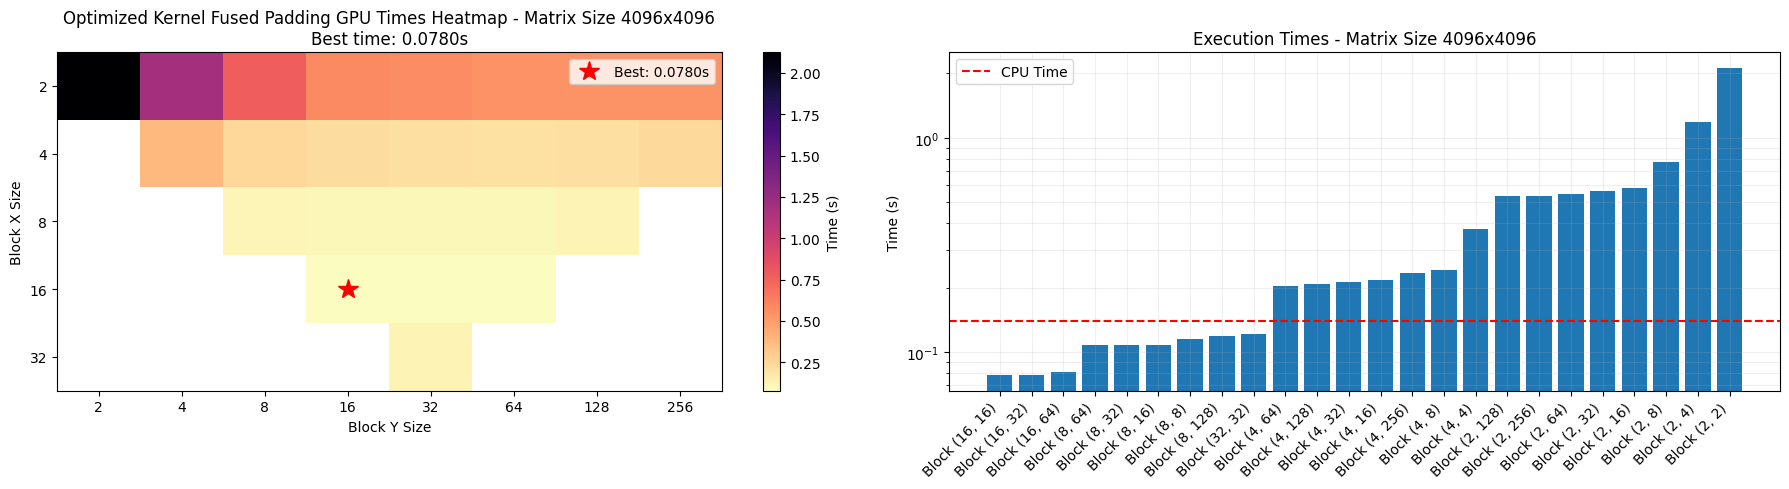

In [23]:
plot_results(results_optimized_fused_padding, 'Optimized Kernel Fused Padding')

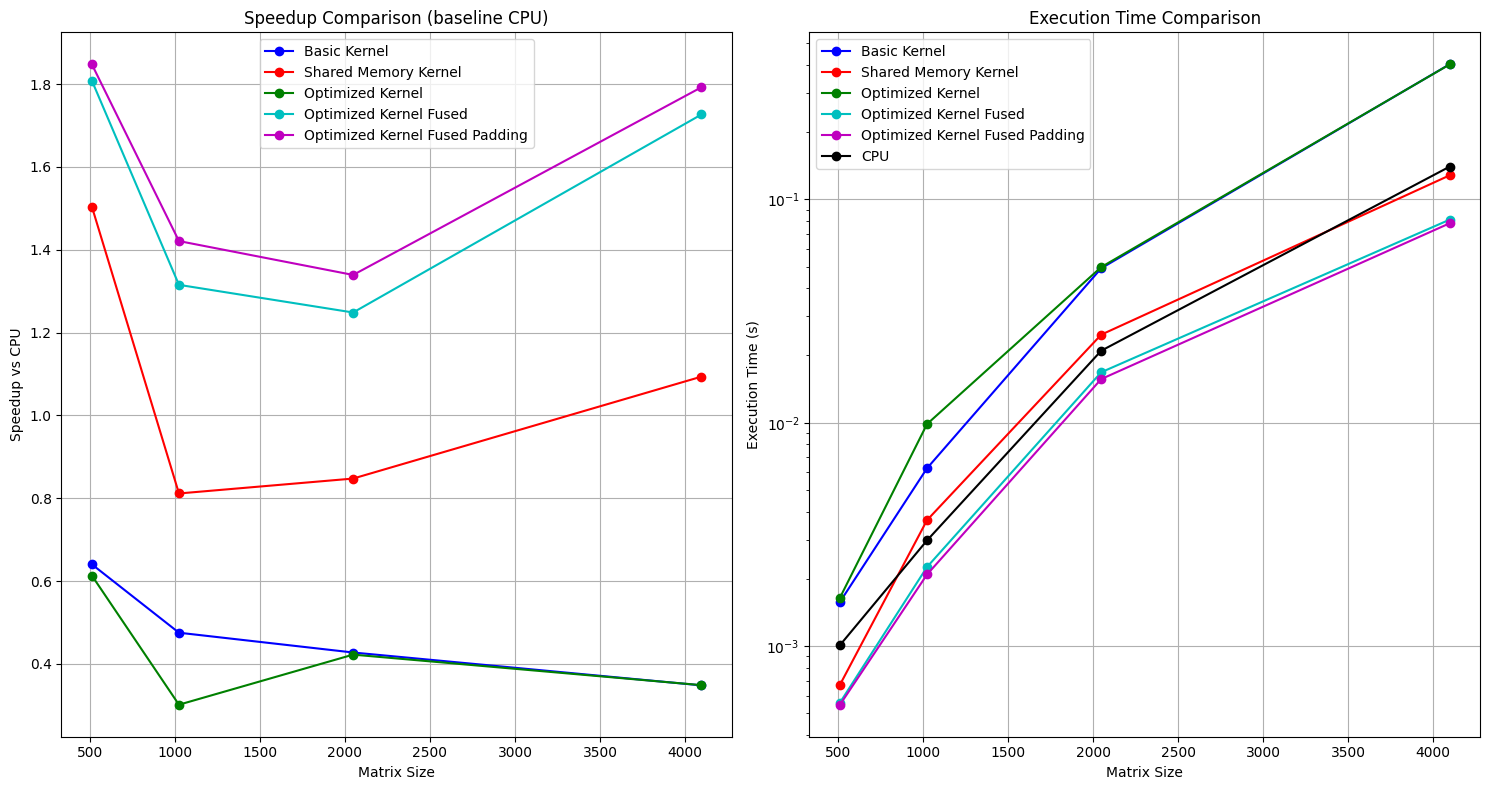


Detailed Performance Comparison:
----------------------------------------------------------------------------------------------------
Matrix Size  | Basic Kernel Time | Shared Memory Kernel Time | Optimized Kernel Time | Optimized Kernel Fused Time | Optimized Kernel Fused Padding Time |   Best Block Size   
----------------------------------------------------------------------------------------------------
    512      |    0.0016    |    0.0007    |    0.0016    |    0.0006    |    0.0005    | (16, 32)
    1024     |    0.0063    |    0.0037    |    0.0099    |    0.0023    |    0.0021    | (16, 16)
    2048     |    0.0491    |    0.0248    |    0.0497    |    0.0168    |    0.0157    | (16, 16)
    4096     |    0.4017    |    0.1279    |    0.4011    |    0.0810    |    0.0780    | (16, 16)


In [24]:
best_times_optimized_fused_padding = {}
for N in matrix_sizes:
    optimized_fused_N_padding = [r for r in results_optimized_fused_padding if r['matrix_size'] == N]
    best_times_optimized_fused_padding[N] = min(optimized_fused_N_padding, key=lambda x: x['gpu_time'])

plot_kernel_comparison([best_times_basic, best_times_shared, best_times_optimized, best_times_optimized_fused, best_times_optimized_fused_padding], 
                      ['Basic Kernel', 'Shared Memory Kernel', 'Optimized Kernel', 'Optimized Kernel Fused', 'Optimized Kernel Fused Padding'],
                      matrix_sizes) 

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [25]:
import random
import numpy as np

def random_image_retriever(n, all_images, all_names):
    """
    Randomly picks n images (with duplicates allowed) from an existing pool 
    of images + names.

    Parameters
    ----------
    n : int
        Number of images to retrieve
    all_images : np.ndarray
        Shape (M, H, W). A collection of M MRI slices
    all_names : list of str
        Corresponding names for the M images

    Returns
    -------
    retrieved_images : np.ndarray
        Shape (n, H, W), duplicates allowed
    retrieved_names : list of str
        Length n, matching retrieved_images
    """
    total_images = len(all_images)
    if total_images == 0:
        raise ValueError("No images available in all_images.")

    retrieved_images = []
    retrieved_names = []
    for _ in range(n):
        idx = random.randint(0, total_images - 1)  # pick any image index
        retrieved_images.append(all_images[idx])
        retrieved_names.append(all_names[idx])

    # Convert list -> np.array
    retrieved_images = np.array(retrieved_images, dtype=all_images.dtype)
    return retrieved_images, retrieved_names

In [26]:
### BEGIN SOLUTION
from numba import cuda, float32

@cuda.jit
def reconstruct_svd_multi_image(U_stack, S_stack, VT_stack, out_stack, ranks):
    """
    Reconstruct multiple images in parallel using partial SVD:
      out_stack[i, row, col] = sum_{r=0..(k_i - 1)} (U_stack[i, row, r] * S_stack[i, r] * VT_stack[i, r, col]).

    Grid layout:
      blockIdx.z => the image index (i)
      blockIdx.x & blockIdx.y => the (row, col) block
      threadIdx.x & threadIdx.y => the local thread within that block
    """
    img_idx = cuda.blockIdx.z
    row = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    col = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y

    if img_idx >= U_stack.shape[0]:
        return
    if row >= U_stack.shape[1]:
        return
    if col >= VT_stack.shape[2]:
        return

    # partial rank for this image
    k_i = ranks[img_idx]
    if k_i <= 0:
        return

    acc = float32(0.0)
    for r in range(k_i):
        acc += (U_stack[img_idx, row, r] *
                S_stack[img_idx, r] *
                VT_stack[img_idx, r, col])

    out_stack[img_idx, row, col] = acc
import math


### END SOLUTION

INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 51200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 34000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 4 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 102400 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 256000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 170000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 20 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 870400 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 51200 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 200 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 34000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 174080 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 102400 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 400 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 68000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFre

Batch size  1: 0.0002 seconds
Batch size  2: 0.0003 seconds


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 204800 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 800 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 136000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 16 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 696320 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 409600 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1600 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 400 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 68000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 8 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 348160 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2

Batch size  4: 0.0002 seconds
Batch size  8: 0.0003 seconds


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 819200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 3200 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 544000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 64 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 2785280 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuEventDestroy_v2 ? bytes
INFO:numb

Batch size 16: 0.0005 seconds


INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1638400 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 6400 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1088000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 272000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 32 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1392640 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 819200 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 3200 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 544000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 64 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 2785280 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1638400 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 6400 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1088000 bytes
INFO:numba.cuda.cudadrv.driver:add pending deall

Batch size 32: 0.0010 seconds


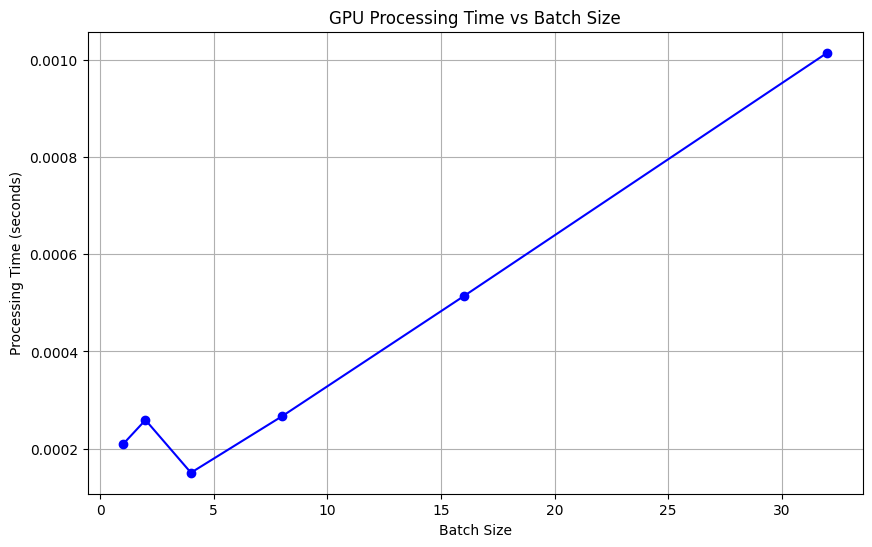

INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 256000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 170000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 20 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 870400 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuEventDestroy_v2 ? bytes


Reconstructed shape: (5, 256, 170)
Ranks used: [50, 50, 50, 50, 50]


In [30]:
def multi_image_reconstruction_example(all_images, all_names, n=5, k_max=40):
    images, names = random_image_retriever(n, all_images, all_names)
    # shape => (n, H, W)
    num_images = images.shape[0]
    H, W = images.shape[1], images.shape[2]

    # 2) CPU-based SVD for each image, store up to k_max
    U_list, S_list, VT_list = [], [], []
    ranks = []
    for i in range(num_images):
        u, s, vt = np.linalg.svd(images[i], full_matrices=False)
        # pick rank
        rank_i = min(u.shape[1], k_max)
        ranks.append(rank_i)
        U_list.append(u[:, :rank_i])
        S_list.append(s[:rank_i])
        VT_list.append(vt[:rank_i, :])

    # 3) Create padded stacks
    U_stack = np.zeros((num_images, H, k_max), dtype=np.float32)
    S_stack = np.zeros((num_images, k_max),    dtype=np.float32)
    VT_stack= np.zeros((num_images, k_max, W), dtype=np.float32)
    for i in range(num_images):
        rnk = ranks[i]
        U_stack[i, :, :rnk]  = U_list[i][:, :rnk]
        S_stack[i, :rnk]     = S_list[i][:rnk]
        VT_stack[i, :rnk, :] = VT_list[i][:rnk, :]

    # 4) GPU arrays
    U_dev   = cuda.to_device(U_stack)
    S_dev   = cuda.to_device(S_stack)
    VT_dev  = cuda.to_device(VT_stack)
    ranks_dev = cuda.to_device(np.array(ranks, dtype=np.int32))
    out_dev = cuda.device_array((num_images, H, W), dtype=np.float32)

    # 5) Grid config
    bx, by = 16, 16
    gridX = math.ceil(H / bx)
    gridY = math.ceil(W / by)
    gridZ = num_images
    grid  = (gridX, gridY, gridZ)
    block = (bx, by, 1)
    
    # warmup
    reconstruct_svd_multi_image[grid, block](U_dev, S_dev, VT_dev, out_dev, ranks_dev)

    start_event = cuda.event()
    stop_event = cuda.event()
    start_event.record()
        
    reconstruct_svd_multi_image[grid, block](U_dev, S_dev, VT_dev, out_dev, ranks_dev)
    
    cuda.synchronize()
    stop_event.record()
    stop_event.synchronize()
    gpu_time = cuda.event_elapsed_time(start_event, stop_event) / 1000  # Convert to seconds

    # 7) Copy results back
    out_stack = out_dev.copy_to_host()
    
    return out_stack, images, names, ranks, gpu_time

# Measure scaling with different batch sizes
batch_sizes = [1, 2, 4, 8, 16, 32]
k_max = 50
times = []
for n in batch_sizes:
    _, _, _, _, t = multi_image_reconstruction_example(images, names, n=n, k_max=k_max)
    times.append(t)
    print(f"Batch size {n:2d}: {t:.4f} seconds")

# Plot scaling behavior
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, times, 'bo-')
plt.xlabel('Batch Size')
plt.ylabel('Processing Time (seconds)')
plt.title('GPU Processing Time vs Batch Size')
plt.grid(True)
plt.show()

# Run a single example for visualization
n = 5
out_stack, orig_images, chosen_names, ranks, _ = multi_image_reconstruction_example(
    images, names, n=n, k_max=k_max)

print("Reconstructed shape:", out_stack.shape)
print("Ranks used:", ranks)

INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 256000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 1000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 4194304 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 8192 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16777216 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 16384 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 67108864 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 256000 bytes
INFO:numba.cuda.cudadrv.driver:dealloc: cuMemFree_v2 1000 bytes
INFO:numba.cuda.cudadrv.driver:add pending dealloc: cuMemFree_v2 170000 bytes
INFO:numba.cuda.cudadrv.driver:add

Reconstructed shape: (5, 256, 170)
Ranks used: [50, 50, 50, 50, 50]


<font color='blue'>Antwort hier eingeben</font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

<font color='blue'>Antwort hier eingeben</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>Antwort hier eingeben inkl. Bild(ern).</font>

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>Antwort hier eingeben</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>Antwort hier eingeben</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>Antwort hier eingeben</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Antwort hier eingeben</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Antwort hier eingeben</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>Antwort hier eingeben</font>